# Week 4 - Counting Words & Phrases

This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words, simple and parsed phrases and explore the statistical properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the correlation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora. 

Then we shift to focus not simply on the *ideas* in a corpus, but also extracting precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases.

We will be introducing spaCy as a package for Computational Linguistics, and also walk you through how to use the Davies Corpora. 

While we wish to avoid using NLTK for heavy corpus analysis, some of its smaller functions can still be useful.

Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages

In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud_2020 #pip install git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

# Retrieving exemplary corpora

To get started we will need some examples. Let's start by downloading one of the corpuses from the Davies set purchased for this class and developed by a computational linguist at Brigham Young University. We can get a list of works available from the [corpora here](https://www.english-corpora.org/).

In this notebook, I will be accessing the data locally - you also have access to this data through the Dropbox download link. The same code can be modified slighlty to access the rest of the corpora on RCC. 
There is a notebook describing this process in the same repository, as well as in the same directory on RCC.

In [2]:
corpus_name = "/Users/bhargavvader/Downloads/Movies"
# corpus_name = "Movies"

This method extracts the text from the zip files and stroes the raw data.

In [3]:
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

In [ ]:
movie_raw = loadcorpus(corpus_name)

In [5]:
movie_raw['11.txt'][0:3]

[b'\r\n',
 b'@@216680 Hey , I \'m talking to you Give me 600 dollars You wish ! That \'s all we \'ve left And you still go to gamble Shut up I earn the money Even that you ca n\'t take it for gamble Shut up What \'re you doing ? Bastard , I \'m gon na beat you You gambling pig , I \'ll beat the shit out of you You bitch I \'ll beat you You dare to hit me with something ! I \'ll kill you All you know is gambling I \'ll beat you What \'re you doing ? Let go of me Stop You \'ll kill Mom Mom , are you all right ? Do n\'t touch my money Dad , where \'re you going ? Go away Dad , do n\'t go Get lost Dad , come back You take Marble with you The way she \'s now Do you want to give me trouble ? I \'m in more trouble than you I am a woman I \'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Do n\'t marry a gambler Hey , 

It seems messy, but nothing we can't clean. This basic method replaces some of the issues with the formatting, and prints the errors if any for debugging. Let us clean one of the raw text files.

We ignore the non-unicode data for convenience for now.

In [4]:
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

In [7]:
clean_11 = clean_raw_text(movie_raw['11.txt'])

In [8]:
clean_11[1]

'@@216680 Hey , I\'m talking to you Give me 600 dollars You wish ! That\'s all we\'ve left And you still go to gamble Shut up I earn the money Even that you can\'t take it for gamble Shut up What\'re you doing ? Bastard , I\'m gon na beat you You gambling pig , I\'ll beat the shit out of you You bitch I\'ll beat you You dare to hit me with something ! I\'ll kill you All you know is gambling I\'ll beat you What\'re you doing ? Let go of me Stop You\'ll kill Mom Mom , are you all right ? Don\'t touch my money Dad , where\'re you going ? Go away Dad , don\'t go Get lost Dad , come back You take Marble with you The way she\'s now Do you want to give me trouble ? I\'m in more trouble than you I am a woman I\'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Don\'t marry a gambler Hey , you want a quarrel ? No , never

This method cleaned a few basic formatting errors. You are welcome to experiment and add your own code to clean the text. Once it begins to look the way you want to, we can start using spaCy to do some heavier cleaning. spaCy does this through the use of language models. Make sure you have the spacy english language model loaded. 

In [11]:
nlp = spacy.load("en")

This model is going to be the basis of most of the tasks which NLTK would have done otherwise. While NLTK uses a bunch of clunky models from multiple places, spacy neatly packs all functionality in one model. This deep trained model will start by doing our word tokenizing and normalising. These methods are already included in lucem illud, and here we will just demonstrate them outside the package so to explain what goes on under the hood.

When we run text through a spacy model, it performs a lot of computation on each of the tokens. Each token is given certain attributes, such as a part of speech, information whether it is a number, a stop word, and so on. 

To perform a tokenization, we check if it is a punctuation or not and add this token. 

In [5]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [11]:
word_tokenize(clean_11[1])

['@@216680',
 'Hey',
 'I',
 "'m",
 'talking',
 'to',
 'you',
 'Give',
 'me',
 '600',
 'dollars',
 'You',
 'wish',
 'That',
 "'s",
 'all',
 'we',
 "'ve",
 'left',
 'And',
 'you',
 'still',
 'go',
 'to',
 'gamble',
 'Shut',
 'up',
 'I',
 'earn',
 'the',
 'money',
 'Even',
 'that',
 'you',
 'ca',
 "n't",
 'take',
 'it',
 'for',
 'gamble',
 'Shut',
 'up',
 'What',
 "'re",
 'you',
 'doing',
 'Bastard',
 'I',
 "'m",
 'gon',
 'na',
 'beat',
 'you',
 'You',
 'gambling',
 'pig',
 'I',
 "'ll",
 'beat',
 'the',
 'shit',
 'out',
 'of',
 'you',
 'You',
 'bitch',
 'I',
 "'ll",
 'beat',
 'you',
 'You',
 'dare',
 'to',
 'hit',
 'me',
 'with',
 'something',
 'I',
 "'ll",
 'kill',
 'you',
 'All',
 'you',
 'know',
 'is',
 'gambling',
 'I',
 "'ll",
 'beat',
 'you',
 'What',
 "'re",
 'you',
 'doing',
 'Let',
 'go',
 'of',
 'me',
 'Stop',
 'You',
 "'ll",
 'kill',
 'Mom',
 'Mom',
 'are',
 'you',
 'all',
 'right',
 'Do',
 "n't",
 'touch',
 'my',
 'money',
 'Dad',
 'where',
 "'re",
 'you',
 'going',
 'Go',
 'a

You can see how the sentence is broken into its constituent words. We can then do some analysis with this. 

Note: we still don't know which movie this is, just that it is raw movie text data. Maybe in the process of our text cleaning and counting we will come across something!

# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [6]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [13]:
countedWords = wordCounter(word_tokenize(clean_11[1]))
countedWords[:10]

count      word
0      1     below
1      3      wish
2      1   unhappy
3      3   chinese
4      1     toast
5      2    rubber
6      2  terrible
7      2     early
8      4  whatever
9      2     wrong

Lets sort and plot our counts to investigate the shape of our word frequency distribution.

First we need to sort the words by count.

In [14]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

count     word
180    302      you
322    191        i
482    126       's
698    112       to
615    109       it
303    106      n't
159    106      the
906     93       do
803     85        a
903     82       me
959     64     what
423     61       is
276     56       go
239     52     have
97      51      for
456     50     your
88      48      'll
731     48     that
437     41      are
770     41      and
17      41       he
148     40       be
932     40       my
595     39       of
192     38     come
107     37      're
848     37      let
25      31       no
696     31      she
96      29       if
..     ...      ...
178     14     will
623     14     give
711     14  husband
414     14       ca
693     13     back
796     13     more
705     12     like
466     12       'd
362     12     away
253     12     stop
251     12      man
19      12       oh
134     11    doing
948     11     want
922     11     girl
66      11      out
690     11      can
138     11      dad
751     10    night
748     10    would
624     10    think
53      10     kill
181     10  postman
727     10      who
336     10    never
505     10     over
823      9      but
37       9     need
804      9      say
526      9   please

[100 rows x 2 columns]

Punctuation and very common words (articles 'a' and 'the'; prepositions 'of' and 'to') make up the most common values, but this isn't very interesting and can actually get in the way of our analysis. We may remove these 'function words' by removing according to a stopword list, setting some frequency threshold, or using a weighting scheme (like tf.idf) to decrease their influence - we will look at these methods in more detail as we go through this tutorial. 

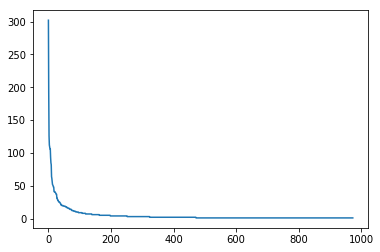

In [15]:
#Creating a figure and axis lets us do things like change the scaling or add a title
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

This shows that likelihood of a word occurring is inversely proportional to its rank. This effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), and suggests that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log (rank order) and log (frequency) resulting in a linear relationship.

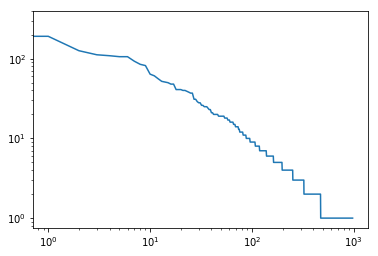

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

(The same relationship occurs in many other rankings, such as population ranks of cities, corporation sizes, income rankings, etc.) 

The distribution was imagined by Zipf to be driven by a principle of 'least effort' where speakers did not work any harder than necessary to communicate a given idea, but the basis for this relationship is still not well understood and conforms at least as well to a process of [preferential attachment](https://en.wikipedia.org/wiki/Preferential_attachment) whereby people disproportionately attend to popular words.


# Getting and working with raw text

First, we will retrieve a collection of press releases from a *GitHub API* that archived them, based on a number of analyses by Justin Grimmer, a political scientist whose work we will read in two weeks!

GitHub API requests are made to `'https://api.github.com/'` and responses are in JSON, similar to Tumblr's API.

We will get the information on [github.com/lintool/GrimmerSenatePressReleases](https://github.com/lintool/GrimmerSenatePressReleases) as it contains a nice set documents.

In [9]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases')
senateReleasesData = json.loads(r.text)
print(senateReleasesData.keys())
print(senateReleasesData['description'])

dict_keys(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'forks_count', 'mirror_url', 'archived', 'disabled', 'open_issues_count', 'lic

What we are interested in here is the `'contents_url'`

In [10]:
print(senateReleasesData['contents_url'])

https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/{+path}


We can use this to get any or all of the files from the repo.

In [11]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse')
whitehouseLinks = json.loads(r.text)
whitehouseLinks[0]

{'name': '10Apr2007Whitehouse123.txt',
 'path': 'raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'sha': 'f524289ee563dca58690c8d36c23dce5dbd9962a',
 'size': 2206,
 'url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
 'html_url': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'git_url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
 'download_url': 'https://raw.githubusercontent.com/lintool/GrimmerSenatePressReleases/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'type': 'file',
 '_links': {'self': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
  'git': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
  'html': 'https:/

Now we have a list of information about Whitehouse press releases. Let's look at one of them.

In [12]:
r = requests.get(whitehouseLinks[0]['download_url'])
whitehouseRelease = r.text
print(whitehouseRelease[:1000])
len(whitehouseRelease)

SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY IN PUSH FOR STEM CELL RESEARCH
  Sharing the story of Lila Barber, a 12 year old girl from Westerly, Sen. Sheldon Whitehouse (D-R.I.) on Tuesday, April 10, 2007, illustrated the hope stem cell research can offer in a speech on the Senate floor in favor of legislation to expand federal funding for stem cell research.  
   Whitehouse met Lila two weeks ago. She was diagnosed two years ago with osteosarcoma, a cancerous bone condition, and last year underwent cadaver bone transplant surgery. The procedure saved her leg and is helping her remain cancer-free, but the transplanted tissue will not grow with her and likely will break down over time. Stem cell research, Whitehouse explained, could vastly improve the care of patients like Lila by allowing surgeons to enhance transplants with a patient's own stem cells, which could replace the lost bone and cartilage, or grow entirely new replacement bones and joints. 
   "Stem cell research gives hope

2206

Now we have a string of correctly encoded text. For analysis of its words, next we need to tokenize it, or split it into a sequence of tokens or word instances.

In [19]:
whTokens = word_tokenize(whitehouseRelease)
whTokens[10:30]

['STEM',
 'CELL',
 'RESEARCH',
 'Sharing',
 'the',
 'story',
 'of',
 'Lila',
 'Barber',
 'a',
 '12',
 'year',
 'old',
 'girl',
 'from',
 'Westerly',
 'Sen.',
 'Sheldon',
 'Whitehouse',
 'D']

Previous iterations of the course used `nltk`s tokenizer, but as we saw before, we used spaCy's model (https://spacy.io/api/tokenizer). We intend to avoid using NLTK when we can - for production level code, it is a lot faster and cleaner to use spaCy.

That being said, `nltk` does have some useful methods for quick analysis of small corpuses. We will explore a few here, and encourage you to figure out for yourself which other ones might be useful.

To use the list of tokens in `nltk`, and take advantage of functions like `concordance`, shown above, we can convert it into a `Text`.

In [7]:
import nltk

In [20]:
whText = nltk.Text(whTokens)

whitehouseIndex = nltk.text.ConcordanceIndex(whText) 
whitehouseIndex.print_concordance('Whitehouse')

Displaying 5 of 5 matches:
ld girl from Westerly Sen. Sheldon Whitehouse D R.I. on Tuesday April 10 2007 il
ral funding for stem cell research Whitehouse met Lila two weeks ago She was dia
 down over time Stem cell research Whitehouse explained could vastly improve the
s research might help or even cure Whitehouse said Whitehouse also praised the e
 help or even cure Whitehouse said Whitehouse also praised the efforts of Rhode 


*Note* that the `Text` class is for doing rapid, exploratory analysis. It provides an easy interface to many of the operations we want to do, but it does not allow us much control over the particular operations it glosses. When you are doing a more complete analysis, you should be using the module specifically designed for that task instead of the shortcut method `Text` provides, e.g. use  [`collocations` Module](http://www.nltk.org/api/nltk.html#module-nltk.collocations) instead of `.collocations()`.

Now that we have gotten this loaded, let's glance at few features we will delve into more deeply later.

For example, we can find words that statistically tend to occur together and typically have a composite, idiomatic meaning irreducible to the semantics of its component words. We will do this later with more control over exactly how these are identified.

Or we can pick a word (or words) and find what words tend to occur around it.

In [24]:
whText.common_contexts(['stem'])

the_cell hope_cell for_cell on_cells joints_cell own_cells
embryonic_cells time_cell of_cell


We can also just count the number of times the word occurs.

In [25]:
whText.count('cell')

5


We can also plot each time a set of words occurs.

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


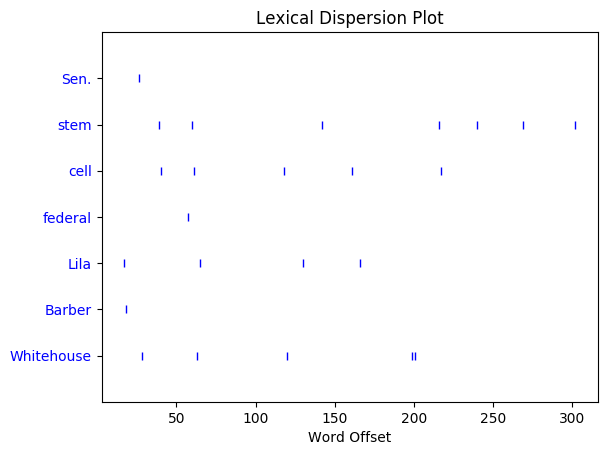

In [26]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Sen.','stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])
sns.set() #Re-enabling seaborn

If we want to do an analysis of all the Whitehouse press releases we will first need to obtain them. By looking at the API we can see the the URL we want is [https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse](https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse), so we can create a function to scrape the individual files.

If you want to know more about downloading from APIs, refer back to the 1st notebook.

In [7]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

whReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse', maxFiles = 10)
whReleases[:5]

name  \
0  10Apr2007Whitehouse123.txt   
1    10Apr2008Whitehouse2.txt   
2    10Apr2008Whitehouse3.txt   
3   10Aug2007Whitehouse78.txt   
4   10Jan2008Whitehouse35.txt   

                                                text  \
0  SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...   
1  SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...   
2  EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...   
3  R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...   
4  SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...   

                                        path  \
0  raw/Whitehouse/10Apr2007Whitehouse123.txt   
1    raw/Whitehouse/10Apr2008Whitehouse2.txt   
2    raw/Whitehouse/10Apr2008Whitehouse3.txt   
3   raw/Whitehouse/10Aug2007Whitehouse78.txt   
4   raw/Whitehouse/10Jan2008Whitehouse35.txt   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   

                                        download_url  
0  https://raw.githubusercontent.com/lintool/Grim...  
1  https://raw.githubusercontent.com/lintool/Grim...  
2  https://raw.githubusercontent.com/lintool/Grim...  
3  https://raw.githubusercontent.com/lintool/Grim...  
4  https://raw.githubusercontent.com/lintool/Grim...

If you are having trouble downloading the data uncomment this next cell

In [28]:
#whReleases = pandas.read_csv('../data/whReleases.csv')

Now we have all the texts in a DataFrame we can look at a few things.

First let's tokenize the texts with the same tokenizer as we used before. We will just save the tokens as a list for now; no need to convert to `Text`s.

In [29]:
whReleases['tokenized_text'] = whReleases['text'].apply(lambda x: word_tokenize(x))

Now lets see how long each of the press releases is:

In [30]:
whReleases['word_counts'] = whReleases['tokenized_text'].apply(lambda x: len(x))
whReleases['word_counts']

0    350
1    311
2    497
3    189
4    236
5    334
6    241
7    469
8    443
9    425
Name: word_counts, dtype: int64

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </span>

In [7]:
# load my corpus
my_corpus_name = "D:/UChicago/Computational Content Analysis/Content-Analysis-2020/data/corpora/COHA"
COHA_raw = loadcorpus(my_corpus_name)

text_1810s_kso.zip
text_1820s_jsi.zip
text_1830s_bsu.zip
text_1840s_nsq.zip
text_1850s_jpr.zip
text_1860s_psi.zip
text_1870s_vuy.zip
text_1880s_azz.zip
text_1890s_jsq.zip
text_1900s_mse.zip
text_1910s_jue.zip
text_1920s_gte.zip
text_1930s_bie.zip
text_1940s_bsw.zip
text_1950s_ndz.zip
text_1960s_xus.zip
text_1970s_jfy.zip
text_1980s_bkk.zip
text_1990s_bsj.zip
text_2000s_scc.zip


In [51]:
# load some object words
import csv
my_words = []
with open('D:/UChicago/Computational Content Analysis/Content-Analysis-2020/project/bad-bad-words/bad-words.csv', newline='') as csvfile:
    csvreader = csv.reader(csvfile)
    for line in csvreader:
        my_words.append(*line)
my_words

['jigaboo',
 'mound of venus',
 'asslover',
 's&m',
 'queaf',
 'whitetrash',
 'meatrack',
 'ra8s',
 'pimp',
 'urine',
 'whit',
 'randy',
 'herpes',
 'niglet',
 'narcotic',
 'pudboy',
 'rimming',
 'boner',
 'pornography',
 'poop chute',
 'israel',
 'dong',
 'slanteye',
 'muffdiving',
 'jiggabo',
 'assassination',
 'peepshpw',
 'popimp',
 'girl on',
 'testicles',
 'laid',
 'molestor',
 'peni5',
 'tranny',
 'barface',
 'hell',
 'arsehole',
 'pissed',
 'sixsixsix',
 'execute',
 'shitty ',
 'conspiracy',
 'hamas',
 'cunilingus',
 'bitcher',
 'muslim',
 'pee',
 'niggled',
 'muffindiver',
 'cocksman',
 'scag',
 'aroused',
 'niggling',
 'fingerfucker ',
 'nlggor',
 'niggaz',
 'assfuck',
 'slant',
 'urinate',
 'mothafucked ',
 'fungus',
 'retard',
 'gummer',
 'venus mound',
 'alla',
 'spaghettinigger',
 'piss',
 'mickeyfinn',
 'fuckers',
 'jizzim',
 'tramp',
 'quashie',
 'prince albert piercing',
 'hardon',
 'menage a trois',
 'bukkake',
 'shag',
 'australian',
 'raped',
 'buggery',
 'deth',
 '

In [12]:
COHA_keys = list(COHA_raw.keys())
nlp.max_length = 2000000
my_tokentized_text = {}
# for simplicity, only including the first 100 keys
for k in COHA_keys[:100]:
    main_text = clean_raw_text(COHA_raw[k])[2]
    my_tokentized_text[k] = word_tokenize(main_text)

In [29]:
from itertools import chain
my_total_tokens = list(chain(*list(my_tokentized_text.values())))
my_total_wordcount = wordCounter(my_total_tokens)
my_total_wordcount.sort_values('count', ascending=False, inplace=True)

In [30]:
# presenting the top 100 used words
my_total_wordcount[:100]

word  count
5         the  89462
20         of  57491
3         and  41591
14         to  40093
52          a  25710
79         in  25349
45       that  16267
119        is  15623
471         i  15113
40         it  13449
42         be  12176
358       his  10590
173      with  10390
120       not  10256
86        for   9741
64         as   9472
129     which   9091
1494      you   8800
65       this   8761
1          by   8734
130        he   8616
574        my   8526
262      have   7953
397       but   7811
11        are   6725
254        on   6532
73       from   6482
131       was   6214
678        's   6092
274     their   5967
...       ...    ...
62       such   2279
273      some   2273
58      these   2272
1506     then   2244
104     other   2243
202     those   2104
35       most   1988
1923      sir   1970
90      every   1923
54      great   1922
311      well   1917
219        us   1858
94        man   1846
718      into   1812
2600      how   1809
319      only   1770
475      time   1725
12361     thy   1708
53       very   1679
498     where   1673
0      states   1670
1369     like   1660
781      here   1565
1001      yet   1516
5514     thou   1472
2253      mr.   1464
570     could   1459
214     state   1452
872      good   1422
233     first   1420

[100 rows x 2 columns]

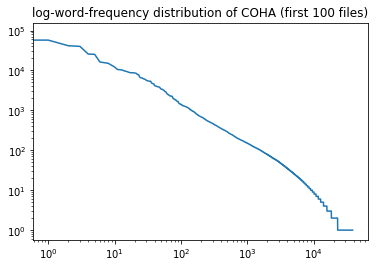

In [47]:
# plotting the log-distribution of the word frequency in the corpus
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(my_total_wordcount)), my_total_wordcount['count'])
ax.set_title("log-word-frequency distribution of COHA (first 100 files)")
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [63]:
# build the subset that contains my objective words
co_words = set(my_total_tokens) & set(my_words)
co_word_count = my_total_wordcount.loc[my_total_wordcount['word'].isin(list(co_words))]
co_word_count

word  count
3582           god   1016
1958         death    715
5930           mad    512
3979          fear    429
492       american    362
2427        period    341
1480          fire    294
8458       servant    270
1255          dead    251
6170           die    250
4857         faith    225
6077     christian    221
1837         slave    209
759         breast    193
8309        church    190
1793        desire    163
12325        devil    159
8291         crime    158
1851     execution    157
2416          laid    153
7675         fight    149
9659           sex    142
355          enemy    142
5405       disease    141
1946         black    139
3536          lies    138
2375          died    132
3586        tongue    126
6614      criminal    123
1978       remains    117
...            ...    ...
33012       nigger      1
37292       babies      1
33416           fu      1
19125  ejaculation      1
21730      fisting      1
7609         horny      1
11051        vomit      1
14333   propaganda      1
13477       tinkle      1
17417          kid      1
27956      swinger      1
3517           abo      1
27542       killer      1
27276       licker      1
27216        spick      1
27385         poop      1
29453         nude      1
29589       looser      1
28703        hussy      1
28649      boobies      1
28551        twink      1
24051         bomb      1
23929     frotting      1
24567         shag      1
24586         smut      1
23556     homicide      1
4191         loser      1
26725         pimp      1
26426        slopy      1
25514   undressing      1

[257 rows x 2 columns]

In [64]:
# testing to see the concordance of the word "god" among all the tokens
import nltk
my_text_object = nltk.Text(my_total_tokens)
my_text_object.concordance('god')

Displaying 25 of 1016 matches:
 of accounts the extracts next 's win God Mr States United the to came mentione
tering continually was but praised be God which visible body his in bone every 
nificant so thing any made he has and God of works the not they Are occupations
xcellent with majesty his endowed had God that was it true that rue by answered
 is what me tell No submissive be and God to rather yourself Address you upon d
your by sworn have you but witness to God called not have You duty a than rathe
then me tell But news disastrous what God Great lost England lost was right the
 Vote sufficient prove may they grant God and supplies Speeches 's Jllirabeau J
I moment critical this at that forbid God but means and ways possible best the 
 his chremonies the of master the and god a still was king the where country a 
tention minute and taste delicate His God of existence the of acknowledgment so
 ruler and upholder creator the be to God eternal and almighty one the acknowle
nning fir

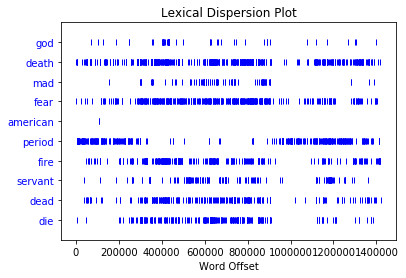

In [66]:
# Exploring the distribution of the first 10 tokens among the text
my_text_object.dispersion_plot(list(co_word_count['word'][:10]))

In [67]:
# testing to see the common_contexts of the word "god"
my_text_object.common_contexts(['god'])

win_mr be_which and_of had_that and_to to_called what_great grant_and
forbid_but and_a his_of to_eternal like_scandinavian has_which when_of
's_but what_good publiclq_some moral_of t_oh


# Filtering and normalizing text

As we want to start comparing the different releases we may choose to do a bit of filtering and normalizing that will allow us to focus on what we most care about. We can first make all of the words lower case, then drop the non-word tokens. Next, we can remove some 'stop words', stem the remaining words to remove suffixes, prefixes and (in some languages) infixes, or lemmatize tokens by intelligently grouping inflected or variant forms of the same word (e.g., with a stemmer and a dictionary). 

To begin this process, we will first define a function to work over the tokenized lists, then another to add normalized tokens to a new column.

We will be using spaCy's built in stop words identifying capacity. When we run text through spaCy's language pipeline, it automatically tags it as a stop word. 

We can remove these stopwords from the analysis by fiat, but we could also take a more principled approach by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection. Alternatively, we could automatically set a cut-off by rule, such as removal of all words more frequent then the most frequent verb, or the most frequent noun (not pronoun), or some term of central interest. 

In [31]:
countsDict = {}
for word in whReleases['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('the', 179),
 ('of', 112),
 ('to', 112),
 ('and', 108),
 ('in', 64),
 ('a', 61),
 ("'s", 50),
 ('that', 41),
 ('our', 39),
 ('for', 35),
 ('is', 33),
 ('on', 33),
 ('Whitehouse', 31),
 ('Iraq', 28),
 ('Bush', 27),
 ('President', 25),
 ('troops', 21),
 ('by', 19),
 ('American', 19),
 ('Rhode', 18)]

We can look at this and pick the cutoff, usually it is at the first noun. So we will cut all words before `'Whitehouse'`.

In [32]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Whitehouse':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['the', 'of', 'to', 'and', 'in', 'a', "'s", 'that', 'our', 'for', 'is', 'on']

If we did have any extra words to add as stop words apart from those normally considered as stop words, we would add it to our stop words by passing it to the normalize tokens method. 

Now we can create our function to normalize the tokens

In [104]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [34]:
whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))

whReleases

download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   
3  https://raw.githubusercontent.com/lintool/Grim...   
4  https://raw.githubusercontent.com/lintool/Grim...   
5  https://raw.githubusercontent.com/lintool/Grim...   
6  https://raw.githubusercontent.com/lintool/Grim...   
7  https://raw.githubusercontent.com/lintool/Grim...   
8  https://raw.githubusercontent.com/lintool/Grim...   
9  https://raw.githubusercontent.com/lintool/Grim...   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   
5  https://github.com/lintool/GrimmerSenatePressR...   
6  https://github.com/lintool/GrimmerSenatePressR...   
7  https://github.com/lintool/GrimmerSenatePressR...   
8  https://github.com/lintool/GrimmerSenatePressR...   
9  https://github.com/lintool/GrimmerSenatePressR...   

                         name                                       path  \
0  10Apr2007Whitehouse123.txt  raw/Whitehouse/10Apr2007Whitehouse123.txt   
1    10Apr2008Whitehouse2.txt    raw/Whitehouse/10Apr2008Whitehouse2.txt   
2    10Apr2008Whitehouse3.txt    raw/Whitehouse/10Apr2008Whitehouse3.txt   
3   10Aug2007Whitehouse78.txt   raw/Whitehouse/10Aug2007Whitehouse78.txt   
4   10Jan2008Whitehouse35.txt   raw/Whitehouse/10Jan2008Whitehouse35.txt   
5    10Mar2008Whitehouse8.txt    raw/Whitehouse/10Mar2008Whitehouse8.txt   
6   10Sep2007Whitehouse72.txt   raw/Whitehouse/10Sep2007Whitehouse72.txt   
7  11Apr2007Whitehouse122.txt  raw/Whitehouse/11Apr2007Whitehouse122.txt   
8  11Jan2007Whitehouse161.txt  raw/Whitehouse/11Jan2007Whitehouse161.txt   
9    11Mar2008Whitehouse7.txt    raw/Whitehouse/11Mar2008Whitehouse7.txt   

                                                text  \
0  SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...   
1  SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...   
2  EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...   
3  R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...   
4  SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...   
5  SENS. REED, WHITEHOUSE WELCOME RHODE ISLAND ST...   
6  REP. WHITEHOUSE ISSUES STATEMENT ON GEN. PETRA...   
7  SEN. WHITEHOUSE URGES BUSH FOR NEW DIRECTION I...   
8  SENS. REED, WHITEHOUSE URGE PORTUGAL TO RECONS...   
9  WHITEHOUSE UNVEILS 'BUSH DEBT': $7.7 TRILLION ...   

                                      tokenized_text  word_counts  \
0  [SEN, WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S, ...          350   
1  [SEN, WHITEHOUSE, SAYS, PRESIDENT, BUSH, MUST,...          311   
2  [EPA, MUST, REVIEW, LEGAL, PROCESS, TO, ROOT, ...          497   
3  [R.I., SENATORS, PRAISE, SEN, DENIAL, OF, LNG,...          189   
4  [SEN, WHITEHOUSE, COMMENTS, ON, ONE, YEAR, ANN...          236   
5  [SENS, REED, WHITEHOUSE, WELCOME, RHODE, ISLAN...          334   
6  [REP, WHITEHOUSE, ISSUES, STATEMENT, ON, GEN, ...          241   
7  [SEN, WHITEHOUSE, URGES, BUSH, FOR, NEW, DIREC...          469   
8  [SENS, REED, WHITEHOUSE, URGE, PORTUGAL, TO, R...          443   
9  [WHITEHOUSE, UNVEILS, BUSH, DEBT, $, 7.7, TRIL...          425   

                                   normalized_tokens  normalized_tokens_count  
0  [sen, whitehouse, share, westerly, girl, story...                      224  
1  [sen, whitehouse, say, president, bush, begin,...                      159  
2  [epa, review, legal, process, root, political,...                      298  
3  [r.i, senator, praise, sen, denial, lng, facil...                      116  
4  [sen, whitehouse, comment, year, anniversary, ...                      125  
5  [sens, reed, whitehouse, welcome, rhode, islan...                      198  
6  [rep, whitehouse, issue, stat

You can see that in the final step of normalizing, we add the lemmatized form of the word. spaCy's built in lemmatizer does this (https://spacy.io/api/lemmatizer). Lemmatization can be thought of as finding the root or the base of the word after removing inflections and other variations of words. Another possible way of finding the roots of words is using NLTK's porting or stemming functionalities, but we will not be getting into them.

Now that it is cleaned we start analyzing the dataset. We can start by finding frequency distributions for the dataset. Lets start looking at all the press releases together. The [`ConditionalFreqDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) class reads in an iterable of tuples, the first element is the condition and the second the focal word. For starters, we will use word lengths as the conditions, but tags or clusters will provide more useful results.

In [35]:
#.sum() adds together the lists from each row into a single list
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))

#print the number of words
print(whcfdist.N())

1966


From this we can lookup the distributions of different word lengths

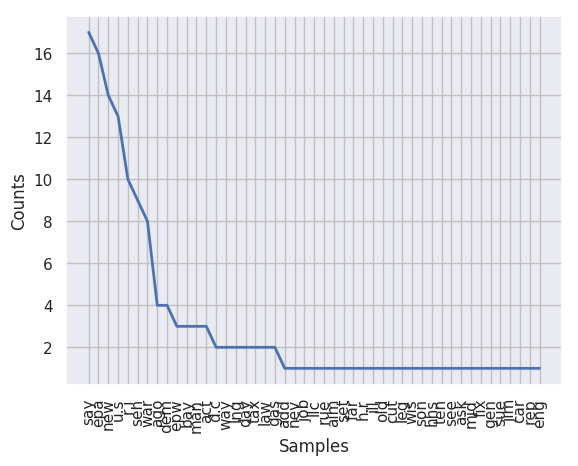

In [36]:
whcfdist[3].plot()

We can also create a Conditional Probability Distribution or [`ConditionalProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) from the `ConditionalFreqDist`. To do this, however, we need a model for the probability distribution. A simple model is [`ELEProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ELEProbDist) which gives the expected likelihood estimate for the probability distribution of the experiment used to generate the observed frequency distribution. 

In [37]:
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(whcpdist[2].max())

#And its probability
print(whcpdist[2].prob(whcpdist[2].max()))

ri
0.25


Length is one feature of a word, but there are many more important features we care about. Another critical feature is a word's role in the sentence, or its part of speech (POS). 

The method below works similarly to ```nltk.pos_text```, and can work with the conditional frequency distributions it provides.

In [142]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags 

In [39]:
whReleases['normalized_tokens_POS'] = [spacy_pos(t) for t in whReleases['text']]

This gives us a new column with the part of speech as a short initialism and the word in a tuple, exactly how the `nltk.ConditionalFreqDist()` function wants them. We can now construct another conditional frequency distribution.

In [40]:
whcfdist_WordtoPOS = nltk.ConditionalFreqDist(whReleases['normalized_tokens_POS'].sum())
list(whcfdist_WordtoPOS.items())[:10]

[('science', FreqDist({'NN': 1})),
 ('congressman', FreqDist({'NN': 1})),
 ('testimony', FreqDist({'NN': 1})),
 ('providence', FreqDist({'NN': 5, 'NNP': 4})),
 ('belonged', FreqDist({'VBD': 1})),
 ('third', FreqDist({'JJ': 1})),
 ('mercury', FreqDist({'NN': 1})),
 ('several', FreqDist({'JJ': 4})),
 ('york', FreqDist({'NNP': 1})),
 ('dredge', FreqDist({'VB': 1}))]

This gives the frequency of each word as each part of speech...which can be uninformative and boring.

What we want is the converse; the frequency of each part of speech for each word.

In [41]:
whcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in whReleases['normalized_tokens_POS'].sum())

We can now identify and collect all of the superlative adjectives

In [42]:
whcfdist_POStoWord['JJ']

FreqDist({'american': 17, 'new': 10, 'portuguese': 9, 'political': 8, 'federal': 6, 'potential': 5, 'clear': 5, 'fiscal': 5, 'official': 4, 'several': 4, ...})

Or look at the most common nouns

In [43]:
whcfdist_POStoWord['NN'].most_common(5)

[('today', 15),
 ('year', 12),
 ('administration', 11),
 ('consulate', 10),
 ('stem', 10)]

Or plot the base form verbs against their number of occurrences

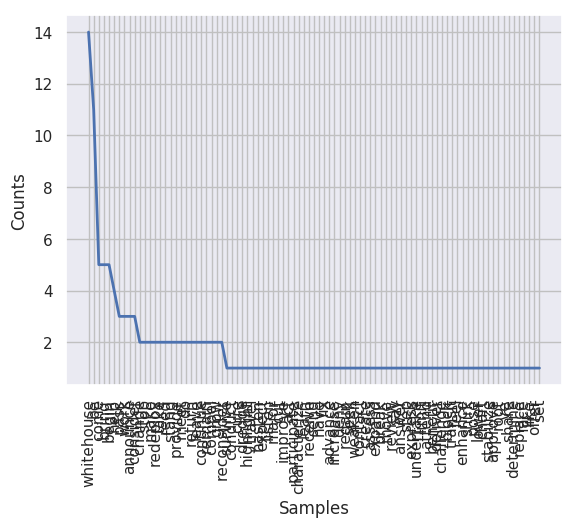

In [44]:
whcfdist_POStoWord['VB'].plot()

We can then do a similar analysis of the word probabilities

In [45]:
whcpdist_POStoWord = nltk.ConditionalProbDist(whcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(whcpdist_POStoWord['NN'].max())

#And its probability
print(whcpdist_POStoWord['NN'].prob(whcpdist_POStoWord['NN'].max()))

today
0.020195439739413682


We can even create a...wait for it...*WORD CLOUD* or Wordl to gaze at and draw mystical, approximate inferences about important nouns and verbs in our corpus:

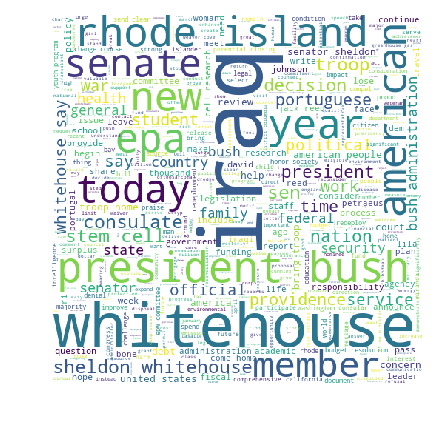

In [46]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(whReleases['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("whitehouse_word_cloud.pdf", format = 'pdf')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</span>

In [98]:
# loading comments already labeled as toxic
my_comments = []
with open('D:/UChicago/Computational Content Analysis/Content-Analysis-2020/project/cleaned-toxic-comments/train_preprocessed.csv', newline='') as csvfile:
    csvreader = csv.reader(csvfile)
    for line in csvreader:
        if line[-2] == str(1.0):
            my_comments.append(line[0])
my_comments

['cock  suck before you piss around on my work',
 'hey  what is it talk what is it  an exclusive group of some wp talibans who are good at destroying  self appointed purist who gang up any one who asks them questions abt their anti social and destructive  non  contribution at wp ask sityush to clean up his behavior than issue me nonsensical warnings ',
 'bye  don t look  come or think of comming back  tosser ',
 'you are  gay  or antisemmitian archangel white tiger  meow  greetingsh uh  there are two ways  why you do erased my comment about ww that holocaust was brutally slaying of jew s and not  gay s gypsys slavs anyone if you are anti semitian  than shave your head bald and go to the skinhead meetings if you doubt words of the bible  that homo sex ity is a deadly sin  make a pentagram tatoo on your forehead go to the satanistic masses with your  gay  pals first and last warning  you fuck  ing  gay i won t appreciate if any more  nazi  shwain would write in my page  i don t wish to t

In [116]:
my_comment_tokens = [word_tokenize(c) for c in my_comments]
print(*my_comment_tokens[:100],sep='\n')

['cock', 'suck', 'before', 'you', 'piss', 'around', 'on', 'my', 'work']
['hey', 'what', 'is', 'it', 'talk', 'what', 'is', 'it', 'an', 'exclusive', 'group', 'of', 'some', 'wp', 'talibans', 'who', 'are', 'good', 'at', 'destroying', 'self', 'appointed', 'purist', 'who', 'gang', 'up', 'any', 'one', 'who', 'asks', 'them', 'questions', 'abt', 'their', 'anti', 'social', 'and', 'destructive', 'non', 'contribution', 'at', 'wp', 'ask', 'sityush', 'to', 'clean', 'up', 'his', 'behavior', 'than', 'issue', 'me', 'nonsensical', 'warnings']
['bye', 'don', 't', 'look', 'come', 'or', 'think', 'of', 'comming', 'back', 'tosser']
['you', 'are', 'gay', 'or', 'antisemmitian', 'archangel', 'white', 'tiger', 'meow', 'greetingsh', 'uh', 'there', 'are', 'two', 'ways', 'why', 'you', 'do', 'erased', 'my', 'comment', 'about', 'ww', 'that', 'holocaust', 'was', 'brutally', 'slaying', 'of', 'jew', 's', 'and', 'not', 'gay', 's', 'gypsys', 'slavs', 'anyone', 'if', 'you', 'are', 'anti', 'semitian', 'than', 'shave', 'your

In [117]:
# normalization
nlp.max_length = 1000000
my_normalized_tokens = [normalizeTokens(c) for c in my_comment_tokens]
print(*my_normalized_tokens[:100],sep='\n')

['cock', 'suck', 'piss', 'work']
['hey', 'talk', 'exclusive', 'group', 'wp', 'talibans', 'good', 'destroy', 'self', 'appoint', 'purist', 'gang', 'ask', 'question', 'abt', 'anti', 'social', 'destructive', 'non', 'contribution', 'wp', 'ask', 'sityush', 'clean', 'behavior', 'issue', 'nonsensical', 'warning']
['bye', 'don', 't', 'look', 'come', 'think', 'comme', 'tosser']
['gay', 'antisemmitian', 'archangel', 'white', 'tiger', 'meow', 'greetingsh', 'uh', 'way', 'erase', 'comment', 'ww', 'holocaust', 'brutally', 'slay', 'jew', 's', 'gay', 's', 'gypsys', 'slavs', 'anti', 'semitian', 'shave', 'head', 'bald', 'skinhead', 'meeting', 'doubt', 'word', 'bible', 'homo', 'sex', 'ity', 'deadly', 'sin', 'pentagram', 'tatoo', 'forehead', 'satanistic', 'masse', 'gay', 'pal', 'warning', 'fuck', 'ing', 'gay', 'win', 't', 'appreciate', 'nazi', 'shwain', 'write', 'page', 'don', 't', 'wish', 'talk', 'anymore', 'beware', 'dark']
['fuck', 'filthy', 'mother', 'ass', 'dry']
['m', 'sorry', 'm', 'sorry', 'screw', 

In [147]:
my_comment_wordcount = wordCounter(list(chain(*my_normalized_tokens)))
my_comment_wordcount.sort_values('count', ascending=False, inplace=True)

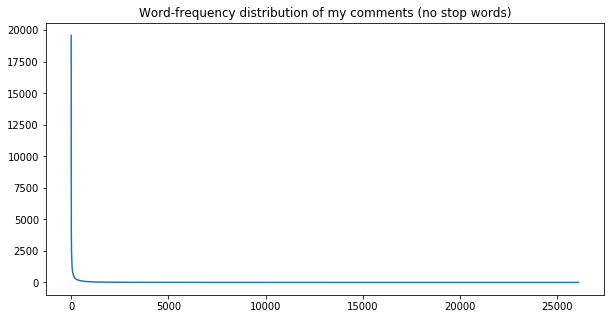

In [152]:
# word frequency plot
plt.rcParams["figure.figsize"] = [10.0, 5.0]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(my_comment_wordcount)), my_comment_wordcount['count'])
ax.set_title("Word-frequency distribution of my comments (no stop words)")
plt.show()

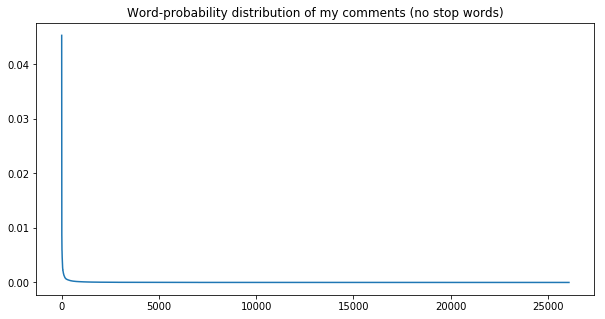

In [165]:
# word probability plot
plt.rcParams["figure.figsize"] = [10.0, 5.0]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(my_comment_wordcount)), my_comment_wordcount['count']/sum(my_comment_wordcount['count']))
ax.set_title("Word-probability distribution of my comments (no stop words)")
plt.show()

In [135]:
# conditional freqency plot, set if the token in the bed word list to be the condition
my_all_tokens = list(chain(*my_normalized_tokens))
my_cf_dist = nltk.ConditionalFreqDist(((w in my_words, w) for w in my_all_tokens))
#print the number of words
print(my_cf_dist.N())

432302


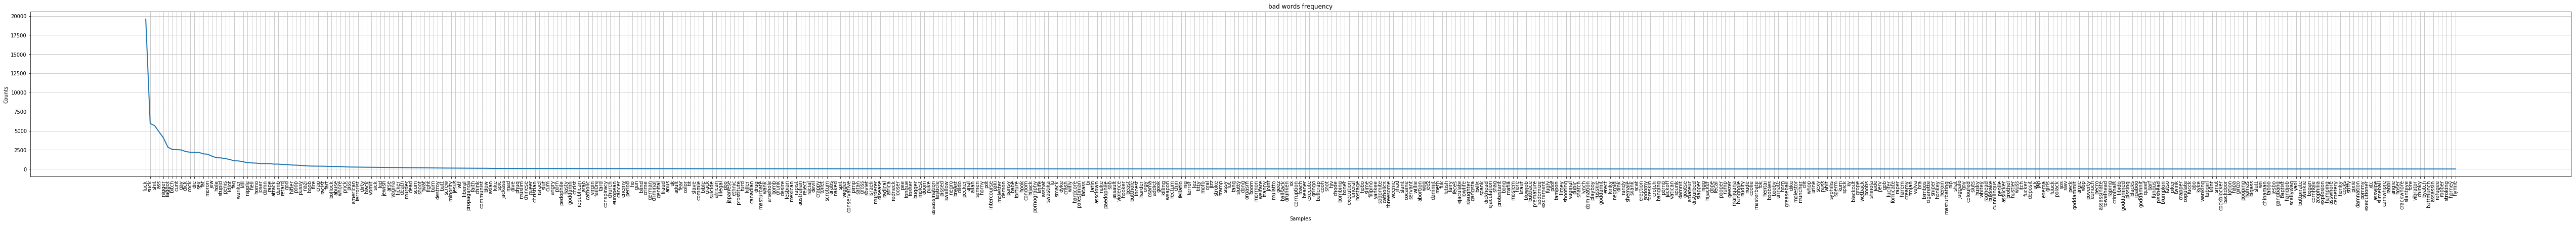

In [149]:
# plot the frequency of the words that are included in the bad word list
plt.rcParams["figure.figsize"] = [90.0, 6.0]
my_cf_dist[True].plot(title='bad words frequency')

In [143]:
my_cp_dist = nltk.ConditionalProbDist(my_cf_dist, nltk.ELEProbDist)
#print the most commonly used 2 words in and out of the bad
print(my_cp_dist[True].max())
print(my_cp_dist[False].max())
#And its probability
print(my_cp_dist[True].prob(my_cp_dist[True].max()))
print(my_cp_dist[False].prob(my_cp_dist[False].max()))

fuck
s
0.20258863543556582
0.02566886490176786


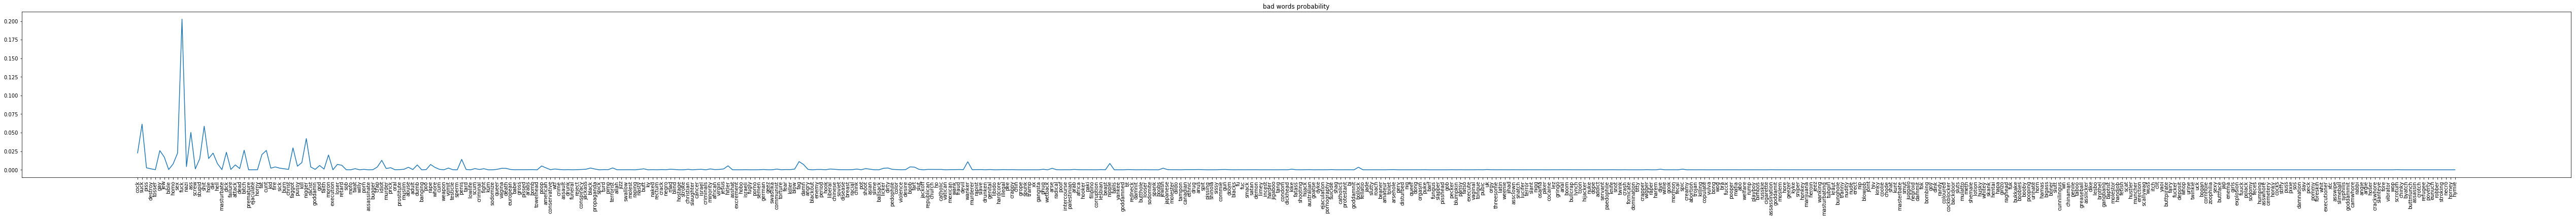

In [168]:
# plot the probability of the words (unsorted) that are included in the bad word list
plt.rcParams["figure.figsize"] = [90.0, 6.0]
fig = plt.figure()
ax = fig.add_subplot(111)
bad_word_samples = list(my_cp_dist[True].samples())
plt.plot(bad_word_samples, [my_cp_dist[True].prob(s) for s in bad_word_samples])
ax.set_title("bad words probability")
plt.xticks(rotation = "vertical")
plt.show()

In [145]:
# labeling POS
my_tokens_POS = [spacy_pos(' '.join(t)) for t in my_normalized_tokens]
my_tokens_POS

[[('cock', 'NNP'), ('suck', 'NN'), ('piss', 'NNP'), ('work', 'NN')],
 [('hey', 'UH'),
  ('talk', 'VBP'),
  ('exclusive', 'JJ'),
  ('group', 'NN'),
  ('wp', 'NN'),
  ('talibans', 'NNPS'),
  ('good', 'JJ'),
  ('destroy', 'VB'),
  ('self', 'NN'),
  ('appoint', 'NN'),
  ('purist', 'NNP'),
  ('gang', 'NN'),
  ('ask', 'NNP'),
  ('question', 'NN'),
  ('abt', 'NNP'),
  ('anti', 'JJ'),
  ('social', 'JJ'),
  ('destructive', 'JJ'),
  ('non', 'JJ'),
  ('contribution', 'NN'),
  ('wp', 'TO'),
  ('ask', 'VB'),
  ('sityush', 'NNP'),
  ('clean', 'JJ'),
  ('behavior', 'NN'),
  ('issue', 'NN'),
  ('nonsensical', 'JJ'),
  ('warning', 'NN')],
 [('bye', 'UH'),
  ('don', 'NNP'),
  ('t', 'NNP'),
  ('look', 'NN'),
  ('come', 'VB'),
  ('think', 'VB'),
  ('comme', 'JJ'),
  ('tosser', 'NN')],
 [('gay', 'NNP'),
  ('antisemmitian', 'NNP'),
  ('archangel', 'NNP'),
  ('white', 'NNP'),
  ('tiger', 'NNP'),
  ('meow', 'NNP'),
  ('greetingsh', 'NNP'),
  ('uh', 'UH'),
  ('way', 'NN'),
  ('erase', 'NN'),
  ('comment', 'NN'

In [173]:
my_total_POS = list(chain(*my_tokens_POS))
my_cf_WordtoPOS = nltk.ConditionalFreqDist(((p, w) for w,p in my_total_POS))

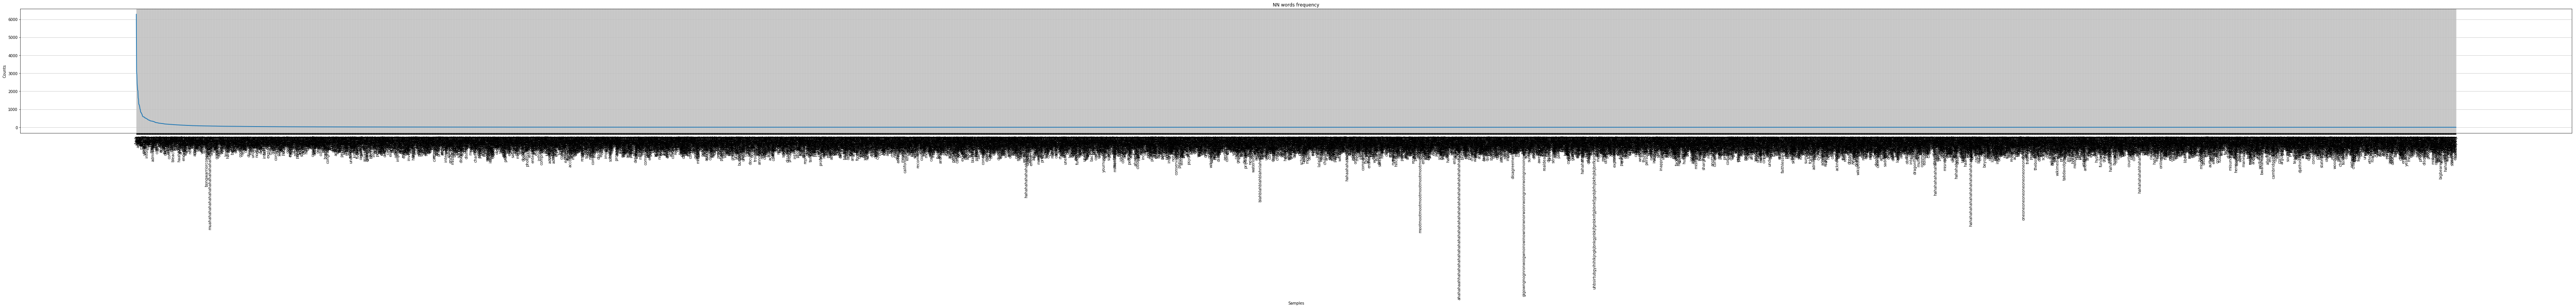

In [174]:
plt.rcParams["figure.figsize"] = [120.0, 6.0]
my_cf_WordtoPOS['NN'].plot(title='NN words frequency')

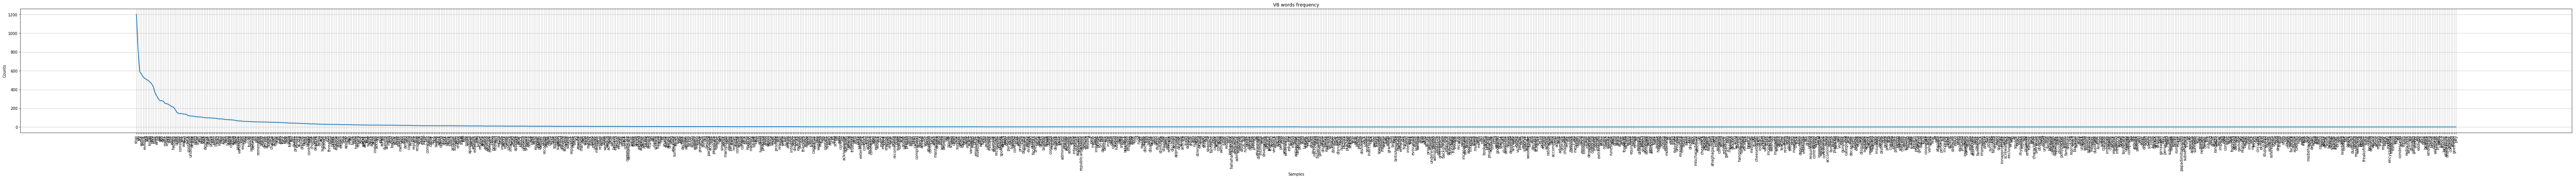

In [180]:
my_cf_WordtoPOS['VB'].plot(title='VB words frequency')

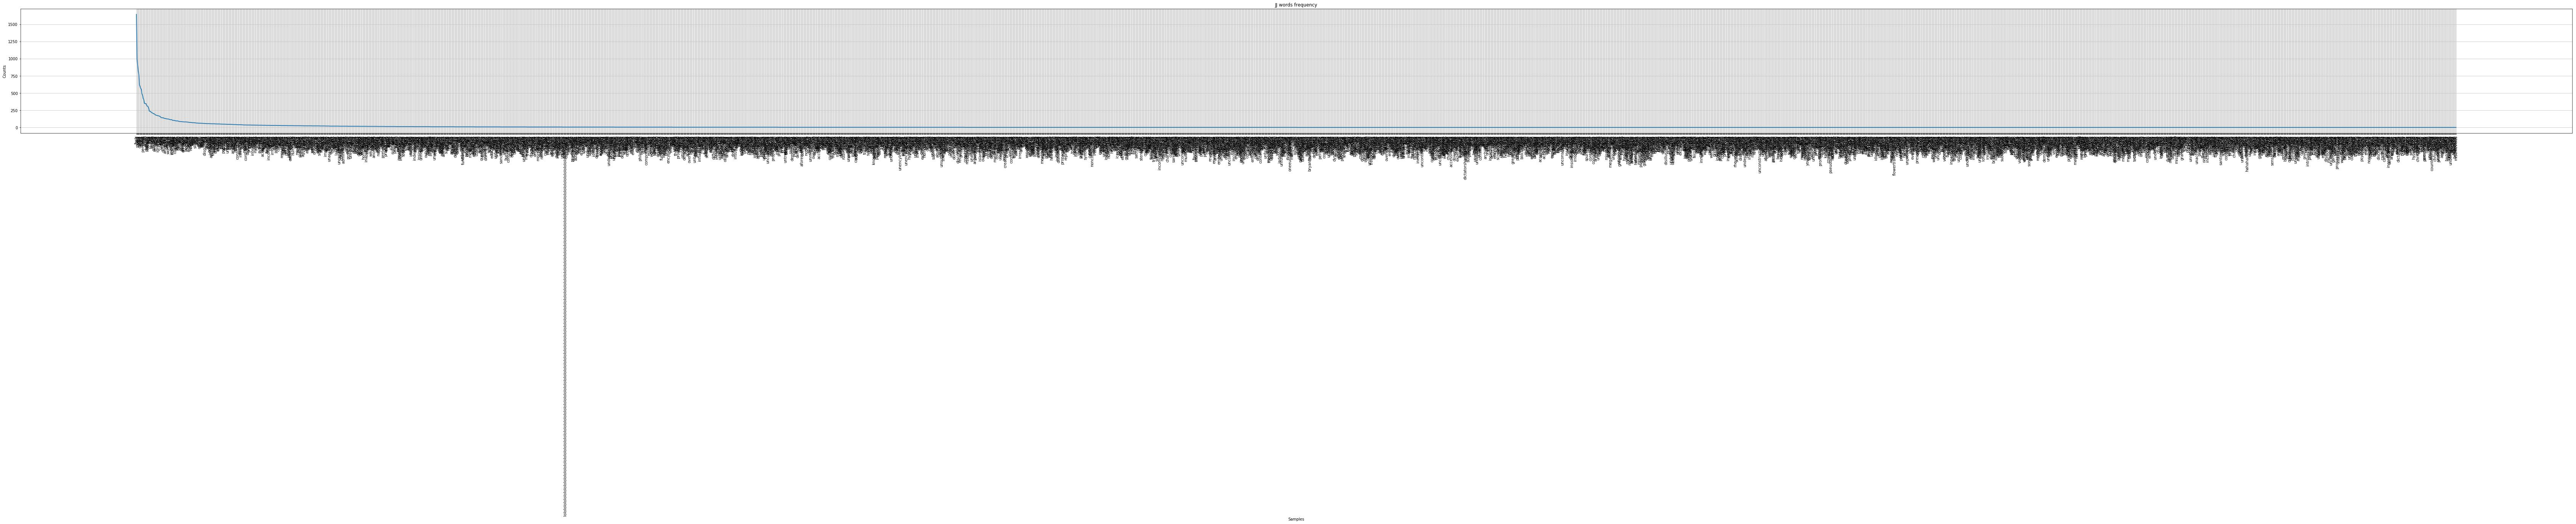

In [176]:
my_cf_WordtoPOS['JJ'].plot(title='JJ words frequency')

In [178]:
my_cp_WordtoPOS = nltk.ConditionalProbDist(my_cf_WordtoPOS, nltk.ELEProbDist)

#print the most common POS word for NN VB and JJ
print("NN max probability:", my_cp_WordtoPOS['NN'].max(), my_cp_WordtoPOS['NN'].prob(my_cp_WordtoPOS['NN'].max()))
print("VB max probability:", my_cp_WordtoPOS['VB'].max(), my_cp_WordtoPOS['VB'].prob(my_cp_WordtoPOS['VB'].max()))
print("JJ max probability:", my_cp_WordtoPOS['JJ'].max(), my_cp_WordtoPOS['JJ'].prob(my_cp_WordtoPOS['JJ'].max()))

NN max probability: fuck 0.04811998391020361
VB max probability: stop 0.05658690383755676
JJ max probability: fuck 0.0401374888777836


(-0.5, 499.5, 499.5, -0.5)

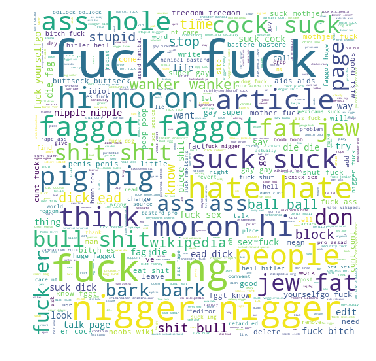

In [179]:
# plot the word cloud 
my_wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(list(chain(*my_normalized_tokens))))
plt.imshow(my_wc)
plt.axis("off")
#plt.savefig("whitehouse_word_cloud.pdf", format = 'pdf')

Through the above visualization results, we can find out that many of those toxic reports include single words that are contained in the bad word list. And at the same time, some aggresive words are highly frequently occured in collocations with other words, and some other are more likely to repeat themselves. In the aspect of part of speech, noun (NN) is the most likely type to occur in the toxic comments followed by adjective (JJ) while verbs are less likely to appear.

## Davies Corpora

Now that we have our basic cleaning down, we can arrange our Davies Corpora. Let us try this with the movies corpora we have already loaded.

We'll use a smaller corpus of a 1000 movies for this demonstration.

In [47]:
zfile = zipfile.ZipFile(corpus_name + "/sources_movies.zip")
source = []

In [48]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [49]:
source[0:20]

[b'textID\tfileID\t#words\tgenre\tyear\tlanguage(s)\tcountry\timdb\ttitle\r\n',
 b'-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\r\n',
 b'\r\n',
 b'290635\t3547424\t4722\tShort, Musical\t1930\tUK\tEnglish\t0290635\tGoodbye to All That\r\n',
 b'21165\t6332374\t10220\tCrime, Mystery, Thriller\t1930\tUK\tEnglish\t0021165\tMurder!\r\n',
 b'21191\t6013789\t5281\tDrama, Romance\t1930\tUSA\tEnglish\t0021191\tA Notorious Affair\r\n',
 b'20620\t3660608\t6724\tBiography, Drama, History\t1930\tUSA\tEnglish\t0020620\tAbraham Lincoln\r\n',
 b'20629\t60053\t9552\tDrama, War\t1930\tUSA\tEnglish, French, German, Latin\t0020629\tAll Quiet on the Western Front\r\n',
 b'20640\t6850720\t13862\tComedy, Musical\t1930\tUSA\tEnglish\t0020640\tAnimal Crackers\r\n',
 b'20641\t176501\t11140\tDrama, Romance\t1930\tUSA\tEnglish\t0020641\tAnna Christie\r\n',
 b'20643\t3603861\t1748\tComedy, Short\t1930\tUSA\tEnglish\t0020643\tAnother Fine Mess\r\n',
 b'20670\t4159455\t6966\tComedy, Musical\t1930\tUS

It looks dirty because the file is encoded as bytes, but we can certainly see the information in here. The file id is also present in the original raw text data: as the first "word". Look back at the normalized/tokenized words to confirm that. We're going to use this to create a dataframe with: Fileid, movie name, genre, year, and country.

It is advised that you run a similar check of the source file before you do other extraction.

First, let us create a dictionary mapping file-id to all the text. Each movie will be mapped to a list of the tokenized words.

In this example, I only use it to load 100 movies. You can comment this out or increase/decrease the number as you see fit.

In [50]:
movie_texts = {}

In [51]:
for files in movie_raw:
    if len(movie_texts) > 100:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        txts = lucem_illud_2020.word_tokenize(movie)
        try:
            movie_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

In [181]:
import pandas as pd

In [53]:
movie_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country", "Tokenized Texts"])

In [54]:
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), movie_texts[fileid.strip()]]
    except KeyError:
        continue

In [55]:
movie_df.head()

Movie Name                     Genre  Year  \
6794028                  Laughter           Comedy, Romance  1930   
3255963               Monte Carlo  Comedy, Musical, Romance  1930   
3116385            The Chain Gang  Animation, Short, Comedy  1930   
3547483  A Co-respondent's Course                    Comedy  1931   
6649883                 Pardon Us      Comedy, Crime, Drama  1931   

                  Country                                    Tokenized Texts  
6794028           English  [So, I, can, call, up, tomorrow, can, I, Pearl...  
3255963   English, French  [Day, of, days, Wonderful, day, of, love, Beau...  
3116385           English  [Shut, up, you, Y, Y, Y, Y, Yes, ma'am, Compan...  
3547483           English  [OOZE, WHO, HELLO, CREEPS, I, LL, BE, WITH, YO...  
6649883  English, Italian  [Laurel, and, Hardy, Pardon, Us, Comedy, 1931,...

# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. We will be using the in-built spaCy pos-tagging.

https://spacy.io/usage/linguistic-features

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

spaCy pos-tags word as we run it through the english language model. A small example:

In [56]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [57]:
for token in sent:
    print(token.text, token.pos_, token.tag_)

Tom PROPN NNP
went VERB VBD
to ADP IN
IKEA PROPN NNP
to PART TO
get AUX VB
some DET DT
of ADP IN
those DET DT
delicious ADJ JJ
Swedish ADJ JJ
meatballs NOUN NNS
. PUNCT .


This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [185]:
redditDF = pandas.read_csv('../data/reddit.csv')

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word). Here, we will use sentences tokenized by spaCy. Like before, these methods can also be found in lucem_illud.



In [182]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [186]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores

Unnamed: 0                author  over_18  score                subreddit  \
9           8        brenkelieshere    False   9448  Tales From Tech Support   
8           7             Bombadils    False  10528  Tales From Tech Support   
7        1200  whenlifegivesyoushit    False  11003            Relationships   
6           6                sfsdfd    False  11295  Tales From Tech Support   
5           5               Raitaro    False  12372  Tales From Tech Support   
4           4           goldie-gold    False  12650  Tales From Tech Support   
3           3        TheDroolinFool    False  13152  Tales From Tech Support   
2           2     Clickity_clickity    False  13404  Tales From Tech Support   
1           1                SECGaz    False  13724  Tales From Tech Support   
0           0      guitarsdontdance    False  14089  Tales From Tech Support   

                                                text  \
9  Last year, Help Desk got a call from a user co...   
8  First post in quite some time! I work at a loc...   
7  [Original Post](https://www.reddit.com/r/relat...   
6  I witnessed this astounding IT meltdown around...   
5  I work Helpdesk for a retail store chain in th...   
4  This just happened...  So, I had a laptop syst...   
3  Another tale from the out of hours IT desk... ...   
2  [Part 1](http://www.reddit.com/r/talesfromtech...   
1  > $Me  - Hello, IT.   > $Usr - Hi, I am still ...   
0  So my story starts on what was a normal day ta...   

                                               title  \
9  How to fix a laptop that won't boot in under a...   
8                  OK, now the password is 'D35p41r'   
7  [UPDATE]My [26 F] with my husband [29 M] 1 yea...   
6  Company-wide email + 30,000 employees + auto-r...   
5  I'm pretty sure I knocked a user out from near...   
4      Engineer is doing drugs!! No. No they aren't.   
3       "I need you to fix Google Bing immediately!"   
2                   Jack, the Worst End User, Part 4   
1              Hi, I am still off sick but I am not.   
0  "Don't bother sending a tech, I'll be dead by ...   

                                                 url  \
9  https://www.reddit.com/r/talesfromtechsupport/...   
8  https://www.reddit.com/r/talesfromtechsupport/...   
7  https://www.reddit.com/r/relationships/comment...   
6  https://www.reddit.com/r/talesfromtechsupport/...   
5  https://www.reddit.com/r/talesfromtechsupport/...   
4  https://www.reddit.com/r/talesfromtechsupport/...   
3  https://www.reddit.com/r/talesfromtechsupport/...   
2  https://www.reddit.com/r/talesfromtechsupport/...   
1  https://www.reddit.com/r/talesfromtechsupport/...   
0  https://www.reddit.com/r/talesfromtechsupport/...   

                                           sentences  
9  [[Last, year, Help, Desk, got, a, call, from, ...  
8  [[First, post, in, quite, some, time], [I, wor...  
7  [[Original, Post](https://www.reddit.com, r, r...  
6  [[I, witnessed, this, astounding, IT, meltdown...  
5  [[I, work, Helpdesk, for, a, retail, store, ch...  
4  [[This, just, happened], [So, I, had, a, lapto...  
3  [[Another, tale, from, the, out, of, hours], [...  
2  [[Part, 1](http://www.reddit.com, r, talesfrom...  
1  [[>], [$, Me], [Hello, IT], [>, $], [Usr, Hi, ...  
0  [[So, my, story, starts, on, what, was, a, nor...

In [184]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [189]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_pos(x))

In [190]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (Help, NNP), (Desk, ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, P...
7    [[(Original, NNP), (Post](https://www.reddit.c...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBD)], [(...
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[(Part, NN), (1](http://www.reddit.com, CD), ...
1    [[(>, XX)], [($, $)], [(Me, PRP)], [(Hello, UH...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [64]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('m', 21),
 ('password', 21),
 ('time', 14),
 ('computer', 13),
 ('lot', 12),
 ('life', 11),
 ('email', 11),
 ('system', 10),
 ('auto', 9),
 ('laptop', 9),
 ('day', 9),
 ('message', 9),
 ('Genius', 9),
 ('office', 8),
 ('story', 8),
 ('call', 8),
 ('today', 8),
 ('part', 8),
 ('job', 7),
 ('something', 7)]

What about the adjectives that modify the word, "computer"?

In [65]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'own', 'unrestricted'}


## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In [210]:
my_comment2 = pd.read_csv("../project/insult-sets/train.csv")
my_insult_comment = my_comment2.loc[my_comment2['Insult']==1]
my_insult_comment

Insult             Date  \
0          1  20120618192155Z   
7          1              NaN   
8          1  20120502173553Z   
9          1  20120620160512Z   
15         1  20120611090207Z   
16         1  20120320162532Z   
18         1  20120320075347Z   
19         1  20120320203947Z   
34         1  20120515132156Z   
37         1  20120620161958Z   
38         1  20120609163743Z   
41         1  20120620075045Z   
45         1  20120619074710Z   
47         1  20120529130844Z   
51         1  20120320131007Z   
55         1  20120502173058Z   
59         1  20120619203151Z   
61         1  20120619033424Z   
79         1  20120619194023Z   
80         1  20120530000452Z   
82         1  20120619162450Z   
88         1  20120619171832Z   
93         1  20120502203704Z   
95         1              NaN   
96         1  20120611215519Z   
97         1  20120515142854Z   
100        1  20120514051227Z   
103        1  20120320212724Z   
106        1  20120619190700Z   
108        1  20120320095936Z   
...      ...              ...   
3848       1  20120618192703Z   
3851       1  20120618221650Z   
3854       1              NaN   
3857       1  20120619201200Z   
3858       1  20120620054110Z   
3863       1  20120619043613Z   
3865       1  20120610123919Z   
3876       1  20120530132041Z   
3878       1  20120529201705Z   
3880       1  20120609170725Z   
3885       1  20120620000450Z   
3894       1  20120610200754Z   
3898       1              NaN   
3904       1  20120610131048Z   
3905       1  20120502193552Z   
3906       1  20120609200647Z   
3908       1  20120609212303Z   
3909       1  20120619153913Z   
3915       1  20120620002507Z   
3916       1  20120619170327Z   
3919       1  20120610154957Z   
3920       1  20120530140143Z   
3924       1  20120530010840Z   
3927       1  20120619003831Z   
3928       1  20120610125954Z   
3929       1  20120619022522Z   
3931       1  20120618222326Z   
3934       1  20120610083604Z   
3935       1  20120515160649Z   
3942       1  20120502172717Z   

                                                Comment  
0                                  "You fuck your dad."  
7     "shut the fuck up. you and the rest of your fa...  
8     "Either you are fake or extremely stupid...may...  
9     "That you are an idiot who understands neither...  
15    "FOR SOME REASON U SOUND RETARDED. LOL. DAMN. ...  
16    "You with the 'racist' screen name\n\nYou are ...  
18                            "your such a dickhead..."  
19       "Your a retard go post your head up your #%&*"  
34    "Allinit123, your\xa0hypocrisy\xa0is sickening...  
37    "I can't believe the stupid people on this sit...  
38                     "fucking behave then you prick!"  
41    "Is that it??  your sum total to any conversat...  
45                                             "faggot"  
47    "Aimless Abe you are a delusion weirdo that sh...  
51        "Even as a troll you are a pathetic failure."  
55         "You're a moron, truth is beyond your reach"  
59    "Your anti-Semitic rants are not welcomed here...  
61       "god, you're tiresome. get a life, you loser."  
79    "Fact : Georgia passed a strict immigration po...  
80              "Of course you would bottom feeder ..."  
82    "You are\xa0 a fukin moron. \xa0\xa0 You are j...  
88    "You are a fucking dumb ass!.  Go back to you ...  
93    "Lets see your papers arealconservati.\n\nTill...  
95    "Correction Bitch! You don't think it's superb...  
96    "I think the only trickle that effected you wa...  
97    "And you keep on your knees and keep telling y...  
100                                     "fuck you both"  
103    "and retards like you back to the institutions."  
106   "Pig Maher, you forgot your meds again. You kn...  
108   "Mr. King isn't it about time you either grow ...  
...                                                 ...  
3848  "Kurius, you said everything that needed to be...  
3851  "YOU SHUT YOUR FUCKlNG MOUTH YOU DlRTY 

In [211]:
# tokenization
my_insult_comment['sentences'] = my_insult_comment['Comment'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x.strip('""'))])
my_insult_comment['sentences']

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0                                [[You, fuck, your, dad]]
7       [[shut, the, fuck, up], [you, and, the, rest, ...
8       [[Either, you, are, fake, or, extremely, stupi...
9       [[That, you, are, an, idiot, who, understands,...
15      [[FOR, SOME, REASON, U, SOUND, RETARDED], [LOL...
16      [[You, with, the, racist, screen], [name\n\nYo...
18                            [[your, such, a, dickhead]]
19      [[Your, a, retard, go, post, your, head, up, y...
34      [[Allinit123, your\xa0hypocrisy\xa0is, sickeni...
37      [[I, ca, n't, believe, the, stupid, people, on...
38                [[fucking, behave], [then, you, prick]]
41      [[Is, that, it], [your, sum, total, to, any, c...
45                                             [[faggot]]
47      [[Aimless, Abe, you, are, a, delusion, weirdo,...
51      [[Even, as, a, troll, you, are, a, pathetic, f...
55      [[You, 're, a, moron, truth, is, beyond, your,...
59      [[Your, anti, Semitic, rants, are, not, welcom...
61      [[god,

In [213]:
# normalization
my_insult_comment['normalized sentences'] = my_insult_comment['sentences'].apply(lambda x: [normalizeTokens(s) for s in x])
my_insult_comment['normalized sentences']

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0                                           [[fuck, dad]]
7       [[shut, fuck], [rest, faggot, friend, burn, st...
8                    [[fake, extremely, stupid], [maybe]]
9          [[idiot, understand, taxation, woman, health]]
15      [[reason, u, sound, retard], [lol], [damn], [u...
16         [[racist, screen], [name\n\nyou, pieceofshit]]
18                                           [[dickhead]]
19                                 [[retard, post, head]]
34      [[allinit123, your\xa0hypocrisy\xa0is, sicken,...
37      [[believe, stupid, people, site, idea], [go], ...
38                           [[fucking, behave], [prick]]
41      [[], [sum, total, conversation], [abuse, call,...
45                                             [[faggot]]
47      [[aimless, abe, delusion, weirdo, lock, inside...
51                           [[troll, pathetic, failure]]
55                                [[moron, truth, reach]]
59      [[anti, semitic, rant, welcome], [racist, moro...
61            

In [393]:
# further cleaninig
import string
import re
def my_clean(sents):
    new_sents = []
    for s in sents:
        cleaned=[]
        for w in s:
            temp1 = re.sub(r'\\+[xnu]\d{0,4}(a0)*',' ', w)
            temp2 = re.sub(r'['+string.punctuation+']', ' ', temp1)
            cleaned += temp2.lower().split()
        if len(cleaned)>0:
            new_sents.append(cleaned)
    return new_sents

In [242]:
my_insult_comment['re-cleaned sentences'] = my_insult_comment['normalized sentences'].apply(lambda x: my_clean(x))
my_insult_comment['re-cleaned sentences']

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


0                                           [[fuck, dad]]
7       [[shut, fuck], [rest, faggot, friend, burn, st...
8                    [[fake, extremely, stupid], [maybe]]
9          [[idiot, understand, taxation, woman, health]]
15      [[reason, u, sound, retard], [lol], [damn], [u...
16           [[racist, screen], [name, you, pieceofshit]]
18                                           [[dickhead]]
19                                 [[retard, post, head]]
34      [[allinit123, your, hypocrisy, is, sicken, ign...
37      [[believe, stupid, people, site, idea], [go], ...
38                           [[fucking, behave], [prick]]
41      [[sum, total, conversation], [abuse, call, tro...
45                                             [[faggot]]
47      [[aimless, abe, delusion, weirdo, lock, inside...
51                           [[troll, pathetic, failure]]
55                                [[moron, truth, reach]]
59      [[anti, semitic, rant, welcome], [racist, moro...
61            

In [243]:
# labeling POS
my_insult_comment['POS'] = my_insult_comment['re-cleaned sentences'].apply(lambda x: tag_sents_pos(x))
my_insult_comment['POS']

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0                             [[(fuck, NNP), (dad, NNP)]]
7       [[(shut, NNP), (fuck, NNP), (rest, NNP), (fagg...
8       [[(fake, JJ), (extremely, RB), (stupid, JJ), (...
9       [[(idiot, NNP), (understand, VB), (taxation, N...
15      [[(reason, NN), (u, NNP), (sound, JJ), (retard...
16      [[(racist, JJ), (screen, NN), (name, VB)], [(y...
18                                    [[(dickhead, NNP)]]
19              [[(retard, VB), (post, NNP), (head, NN)]]
34      [[(allinit123, UH), (your, PRP$), (hypocrisy, ...
37      [[(believe, VB), (stupid, JJ), (people, NNS), ...
38         [[(fucking, UH), (behave, NNP), (prick, NNP)]]
41      [[(sum, NNP), (total, JJ), (conversation, NN),...
45                                      [[(faggot, NNP)]]
47      [[(aimless, NNP), (abe, NNP), (delusion, NNP),...
51        [[(troll, NNP), (pathetic, JJ), (failure, NN)]]
55            [[(moron, NNP), (truth, NNP), (reach, VB)]]
59      [[(anti, JJ), (semitic, JJ), (rant, JJ), (welc...
61      [[(god

In [234]:
# Examine words with the label NN, VB and JJ
def single_POS_list(countTarget, sents_list):
    targetCounts = {}
    for entry in sents_list:
        for sentence in entry:
            for ent, kind in sentence:
                if kind != countTarget:
                    continue
                elif ent in targetCounts:
                    targetCounts[ent] += 1
                else:
                    targetCounts[ent] = 1
    return sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)

In [244]:
single_POS_list('NN',my_insult_comment['POS'])

[('bitch', 78),
 ('life', 55),
 ('time', 50),
 ('ass', 47),
 ('idiot', 43),
 ('comment', 42),
 ('shit', 38),
 ('man', 32),
 ('fact', 26),
 ('fool', 25),
 ('troll', 25),
 ('year', 25),
 ('child', 25),
 ('talk', 25),
 ('way', 25),
 ('post', 24),
 ('moron', 24),
 ('woman', 21),
 ('piece', 20),
 ('family', 20),
 ('thing', 20),
 ('loser', 19),
 ('money', 19),
 ('point', 19),
 ('face', 19),
 ('mother', 18),
 ('person', 18),
 ('mom', 17),
 ('sound', 17),
 ('word', 17),
 ('world', 16),
 ('head', 15),
 ('crap', 15),
 ('hole', 15),
 ('boy', 15),
 ('job', 14),
 ('pussy', 14),
 ('girl', 14),
 ('internet', 14),
 ('friend', 13),
 ('pay', 13),
 ('day', 13),
 ('retard', 12),
 ('dog', 12),
 ('picture', 12),
 ('suck', 12),
 ('trash', 12),
 ('brain', 12),
 ('guy', 12),
 ('kid', 12),
 ('look', 11),
 ('call', 11),
 ('lie', 11),
 ('history', 11),
 ('mind', 11),
 ('asshole', 11),
 ('work', 10),
 ('self', 10),
 ('school', 10),
 ('r', 10),
 ('rape', 10),
 ('race', 10),
 ('fuck', 10),
 ('today', 10),
 ('screen'

In [245]:
single_POS_list('VB',my_insult_comment['POS'])

[('know', 34),
 ('go', 32),
 ('come', 32),
 ('stop', 30),
 ('think', 29),
 ('tell', 27),
 ('get', 27),
 ('try', 25),
 ('say', 21),
 ('let', 13),
 ('grow', 12),
 ('wait', 11),
 ('look', 11),
 ('feel', 10),
 ('mean', 10),
 ('write', 10),
 ('make', 10),
 ('give', 9),
 ('kill', 9),
 ('post', 9),
 ('pay', 9),
 ('prove', 8),
 ('suck', 8),
 ('happen', 8),
 ('find', 8),
 ('eat', 8),
 ('retard', 7),
 ('buy', 7),
 ('learn', 7),
 ('sound', 7),
 ('understand', 6),
 ('forget', 6),
 ('ass', 6),
 ('start', 6),
 ('bring', 6),
 ('take', 6),
 ('lose', 6),
 ('ask', 6),
 ('want', 6),
 ('live', 6),
 ('pass', 5),
 ('stand', 5),
 ('fight', 5),
 ('sit', 5),
 ('check', 5),
 ('die', 5),
 ('read', 5),
 ('see', 5),
 ('call', 4),
 ('deserve', 4),
 ('pull', 4),
 ('compare', 4),
 ('watch', 4),
 ('stay', 4),
 ('add', 4),
 ('link', 3),
 ('shove', 3),
 ('complete', 3),
 ('meet', 3),
 ('kick', 3),
 ('comment', 3),
 ('explain', 3),
 ('save', 3),
 ('hear', 3),
 ('listen', 3),
 ('avoid', 3),
 ('speak', 3),
 ('turn', 3),
 (

In [246]:
single_POS_list('JJ',my_insult_comment['POS'])

[('stupid', 77),
 ('dumb', 67),
 ('little', 67),
 ('black', 45),
 ('good', 43),
 ('ignorant', 41),
 ('pathetic', 33),
 ('bad', 30),
 ('old', 26),
 ('white', 24),
 ('big', 23),
 ('sick', 20),
 ('racist', 18),
 ('real', 17),
 ('poor', 16),
 ('sure', 15),
 ('fucking', 15),
 ('right', 15),
 ('funny', 14),
 ('fake', 13),
 ('gay', 13),
 ('idiotic', 12),
 ('fat', 12),
 ('live', 12),
 ('human', 11),
 ('nice', 11),
 ('fuck', 11),
 ('sad', 11),
 ('complete', 10),
 ('liberal', 10),
 ('low', 9),
 ('ugly', 9),
 ('dead', 9),
 ('hard', 9),
 ('entire', 9),
 ('sorry', 8),
 ('intelligent', 8),
 ('weak', 8),
 ('true', 8),
 ('conservative', 8),
 ('easy', 8),
 ('dirty', 7),
 ('filthy', 7),
 ('special', 7),
 ('illegal', 7),
 ('worthless', 7),
 ('afraid', 7),
 ('great', 7),
 ('selfish', 6),
 ('proud', 6),
 ('long', 6),
 ('new', 6),
 ('strong', 6),
 ('disgusting', 6),
 ('typical', 5),
 ('evil', 5),
 ('medical', 5),
 ('nazi', 5),
 ('nasty', 5),
 ('small', 5),
 ('second', 5),
 ('smart', 5),
 ('decent', 5),
 ('s

In [258]:
# I would like to see the relationships between NN words and JJ words, are those frequently used NN words and JJ words (top 5) always combined together or not
NN_sorted_list = single_POS_list('NN',my_insult_comment['POS'])
JJ_sorted_list = single_POS_list('JJ',my_insult_comment['POS'])
NN_dict = dict(NN_sorted_list)
JJ_dict = dict(JJ_sorted_list)

In [269]:
# conditional NN_JJ associations
def NN_JJ_association_POS(Word, sents_list):
    NResults = set()
    for entry in sents_list:
        for sentence in entry:
            for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
                if (kind1,ent2.lower())==('JJ', Word):
                    rank = JJ_sorted_list.index((ent1, JJ_dict[ent1]))+1
                    NResults.add((ent1,rank))
                else:
                    continue
    return NResults

In [270]:
NN_JJ_match_result = map(lambda x:NN_JJ_association_POS(x, my_insult_comment['POS']), [x[0] for x in NN_sorted_list[:5]])
NN_JJ_match_dict = dict(zip([x[0] for x in NN_sorted_list[:5]], NN_JJ_match_result))

In [271]:
NN_JJ_match_dict

{'bitch': {('arrogant', 79),
  ('big', 11),
  ('dumb', 2),
  ('fucking', 17),
  ('little', 3),
  ('naive', 141),
  ('old', 9),
  ('pathetic', 7),
  ('sick', 12),
  ('strong', 53),
  ('stupid', 1),
  ('ugly', 32),
  ('weak', 38)},
 'life': {('entire', 35),
  ('fucking', 17),
  ('live', 24),
  ('low', 31),
  ('mean', 80),
  ('mediocre', 380),
  ('miserable', 65),
  ('pathetic', 7),
  ('real', 14),
  ('sick', 12),
  ('special', 44),
  ('suspicious', 516),
  ('thorough', 331)},
 'time': {('dumb', 2),
  ('english', 157),
  ('genious', 240),
  ('hard', 34),
  ('little', 3),
  ('long', 51),
  ('real', 14),
  ('worth', 102)},
 'ass': {('big', 11),
  ('black', 4),
  ('bored', 477),
  ('dead', 33),
  ('dirty', 42),
  ('dumb', 2),
  ('fake', 20),
  ('fat', 23),
  ('gigantic', 229),
  ('hairy', 474),
  ('hard', 34),
  ('ignorant', 6),
  ('lazy', 155),
  ('long', 51),
  ('own', 349),
  ('soft', 128),
  ('strong', 53),
  ('ugly', 32),
  ('weak', 38),
  ('white', 10),
  ('worthless', 46)},
 'idiot': 

In [272]:
# conditional JJ_NN associations
def JJ_NN_association_POS(Word, sents_list):
    NResults = set()
    for entry in sents_list:
        for sentence in entry:
            for (ent1, kind1),(ent2, kind2) in zip(sentence[:-1], sentence[1:]):
                if (kind2, ent1.lower())==('NN', Word):
                    rank = NN_sorted_list.index((ent2, NN_dict[ent2]))+1
                    NResults.add((ent2,rank))
                else:
                    continue
    return NResults
JJ_NN_match_result = map(lambda x:JJ_NN_association_POS(x, my_insult_comment['POS']), [x[0] for x in JJ_sorted_list[:5]])
JJ_NN_match_dict = dict(zip([x[0] for x in JJ_sorted_list[:5]], JJ_NN_match_result))

In [273]:
JJ_NN_match_dict

{'stupid': {('bitch', 1),
  ('care', 86),
  ('child', 13),
  ('comment', 6),
  ('idiot', 5),
  ('imbecile', 676),
  ('liar', 135),
  ('libtard', 326),
  ('mentality', 1329),
  ('one', 890),
  ('pearce', 922),
  ('remark', 820),
  ('reply', 155),
  ('shit', 7),
  ('slut', 292),
  ('talk', 14),
  ('understand', 170),
  ('watch', 88),
  ('work', 57),
  ('writer', 1327),
  ('yesterday', 626),
  ('yuppie', 734)},
 'dumb': {('article', 87),
  ('ass', 4),
  ('bastard', 465),
  ('bitch', 1),
  ('choice', 206),
  ('choose', 435),
  ('click', 280),
  ('d', 169),
  ('day', 42),
  ('family', 20),
  ('fuuuuck', 611),
  ('guy', 49),
  ('hold', 376),
  ('idiot', 5),
  ('knowledge', 406),
  ('look', 51),
  ('loser', 22),
  ('opinion', 122),
  ('phone', 214),
  ('phuckface', 1377),
  ('piece', 19),
  ('retard', 43),
  ('sound', 29),
  ('tea', 115),
  ('time', 3),
  ('understand', 170)},
 'little': {('asshole', 56),
  ('bit', 205),
  ('bitch', 1),
  ('bone', 450),
  ('boy', 35),
  ('child', 13),
  ('cow

As for nouns and adjectives that appear frequently, they may be paired with other high-frequency words or appear together with low-frequency words. There are two sources of high-frequency word formation: one is to form a combination with other words extensively, and the other is to form a high-frequency match with a few certain words. This can be combined with the collocation analysis in the next section.

As illustrated above, we might want to find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (*n*-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length *n*). 

We will begin with the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-grams.

In [66]:
whBigrams = nltk.collocations.BigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(whBigrams.N))

There are 1966 bigrams in the finder


To compare the bigrams we need to tell nltk what our score function is. Initially, we will look at the raw counts.

In [67]:
def bigramScoring(count, wordsTuple, total):
    return count

print(whBigrams.nbest(bigramScoring, 10))

[('president', 'bush'), ('rhode', 'island'), ('sheldon', 'whitehouse'), ('stem', 'cell'), ('whitehouse', 'd'), ('d', 'r.i'), ('bush', 'administration'), ('whitehouse', 'say'), ('american', 'people'), ('bring', 'troop')]


One note about how `BigramCollocationFinder` works. It doesn't use the strings internally.

In [68]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

whBigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The first word is:  5, The second word is: 3
The first word is:  17, The second word is: 3
The first word is:  4, The second word is: 6
The first word is:  4, The second word is: 3
The first word is:  4, The second word is: 32
The first word is:  1, The second word is: 2
The first word is:  1, The second word is: 15
The first word is:  10, The second word is: 4
The first word is:  3, The second word is: 6
The first word is:  1, The second word is: 4


The words are each given numeric IDs and there is a dictionary that maps the IDs to the words they represent. This is a common performance optimization.

Two words can appear together by chance. Recall from  Manning and Schütze's textbook that a t-value can be computed for each bigram to see how significant the association is. You may also want to try computing the $\chi^2$, likelihood ratio, and pointwise mutual information statistics. 

In [69]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
whBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('rhode', 'island'), 178.4626724897413),
 (('stem', 'cell'), 146.29899697399068),
 (('president', 'bush'), 126.26729276568966),
 (('sheldon', 'whitehouse'), 97.4298528095992),
 (('d', 'r.i'), 84.9146961271807),
 (('united', 'states'), 81.48563202934115),
 (('whitehouse', 'd'), 57.76763043351339),
 (('senator', 'sheldon'), 49.72259487860021),
 (('jack', 'reed'), 46.48119675073579),
 (('american', 'people'), 46.36945188839907),
 (('bush', 'administration'), 45.46512896674145),
 (('honor', 'society'), 44.90628391896907),
 (('bring', 'troop'), 43.09168928304577),
 (('cell', 'research'), 41.09314736916158),
 (('d', 'ri'), 39.02133612474179),
 (('potential', 'closing'), 38.1761672488765),
 (('youth', 'program'), 38.1761672488765),
 (('u.s', 'senator'), 37.29814426167994),
 (('troop', 'home'), 36.67811523401771),
 (('come', 'home'), 36.52843915939549),
 (('epw', 'committee'), 34.32127210844136),
 (('whitehouse', 'say'), 33.11262200306782),
 (('budget', 'resolution'), 32.092896259399076),
 (

There are a few other available measures

In [70]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

We can also look at trigrams

In [71]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('sheldon', 'whitehouse', 'd'), 3.1616100497095263),
 (('whitehouse', 'd', 'r.i'), 2.6450863551309975),
 (('bring', 'troop', 'home'), 2.449193154185041),
 (('senator', 'sheldon', 'whitehouse'), 2.4489320548208684),
 (('stem', 'cell', 'research'), 2.2359180252547137),
 (('u.s', 'senator', 'sheldon'), 2.2358694296197354),
 (('senate', 'youth', 'program'), 1.732017198625133),
 (('united', 'states', 'senator'), 1.7319916558278872),
 (('jack', 'reed', 'd'), 1.7319695486115574),
 (('new', 'direction', 'iraq'), 1.7318500501449103),
 (('rhode', 'island', 'state'), 1.7316952996306025),
 (('whitehouse', 'd', 'ri'), 1.7316445127822775),
 (('sen', 'sheldon', 'whitehouse'), 1.7314055158489832),
 (('reconsider', 'potential', 'closing'), 1.4142080740555638),
 (('responsibility', 'security', 'governance'), 1.414204781065045),
 (('$', 'foregone', 'surplus'), 1.4142018539623618),
 (('senators', 'jack', 'reed'), 1.4142018539623618),
 (('v.', 'epa', 'decide'), 1.4142018539623618),
 (('cell', 'enhancemen

Or n-grams (for any number n)

In [72]:
Ngrams = nltk.ngrams(whReleases['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('iraq', 'sen', 'sheldon', 'whitehouse'): 2, ('stem', 'cell', 'research', 'whitehouse'): 2, ('u.s', 'senators', 'jack', 'reed'): 2, ('sen', 'sheldon', 'whitehouse', 'd'): 2, ('reed', 'd', 'r.i', 'sheldon'): 2, ('senators', 'jack', 'reed', 'd'): 2, ('portuguese', 'american', 'citizen', 'rhode'): 2, ('d', 'ri', 'say', 'today'): 2, ('senator', 'sheldon', 'whitehouse', 'd'): 5, ('american', 'citizen', 'rhode', 'island'): 2, ('jack', 'reed', 'd', 'r.i'): 2, ('bring', 'troop', 'home', 'iraq'): 2, ('sheldon', 'whitehouse', 'd', 'r.i'): 7, ('california', 'rhode', 'island', 'state'): 2, ('begin', 'bring', 'troop', 'home'): 2, ('u.s', 'senator', 'sheldon', 'whitehouse'): 5, ('whitehouse', 'd', 'ri', 'say'): 2, ('member', 'senate', 'select', 'committee'): 2, ('senate', 'select', 'committee', 'intelligence'): 2, ('r.i', 'sheldon', 'whitehouse', 'd'): 2, ('d', 'r.i', 'sheldon', 'whitehouse'): 2, ('stem', 'cell', 'enhancement', 'act'): 2, ('sheldon', 'whitehouse', 'd', 'ri'): 3}


Gensim is another important python text processing package which allows us to use collocations, among other cool methods (which we will explore later weeks).

In [73]:
import gensim

In [74]:
bigram = gensim.models.Phrases(whReleases['normalized_tokens'])

In [75]:
texts = [bigram[line] for line in whReleases['normalized_tokens']]

In [76]:
texts[0]

['sen',
 'whitehouse',
 'share',
 'westerly',
 'girl',
 'story',
 'push',
 'stem_cell',
 'research',
 'share',
 'story',
 'lila',
 'barber',
 'year',
 'old',
 'girl',
 'westerly',
 'sen',
 'sheldon_whitehouse',
 'd_r.i',
 'tuesday',
 'april',
 'illustrate',
 'hope',
 'stem_cell',
 'research',
 'offer',
 'speech',
 'senate',
 'floor',
 'favor',
 'legislation',
 'expand',
 'federal',
 'funding',
 'stem_cell',
 'research',
 'whitehouse',
 'meet',
 'lila',
 'week',
 'ago',
 'diagnose',
 'year',
 'ago',
 'osteosarcoma',
 'cancerous',
 'bone',
 'condition',
 'year',
 'undergo',
 'cadaver',
 'bone',
 'transplant',
 'surgery',
 'procedure',
 'save',
 'leg',
 'help',
 'remain',
 'cancer',
 'free',
 'transplanted',
 'tissue',
 'grow',
 'likely',
 'break',
 'time',
 'stem_cell',
 'research',
 'whitehouse',
 'explain',
 'vastly',
 'improve',
 'care',
 'patient',
 'like',
 'lila',
 'allow',
 'surgeon',
 'enhance',
 'transplant',
 'patient',
 'stem_cell',
 'replace',
 'lose',
 'bone',
 'cartilage',


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<span style="color:red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</span> 

In [280]:
# define score-function
def my_score_func(count, word_freq_tuple, all):
    return count

In [281]:
# bigrams
my_bigrams = nltk.collocations.BigramCollocationFinder.from_words(list(chain(*my_normalized_tokens)))
my_bigrams.score_ngrams(my_score_func)

[(('fuck', 'fuck'), 4779.0),
 (('don', 't'), 2559.0),
 (('fuck', 'ing'), 2467.0),
 (('nigger', 'nigger'), 2022.0),
 (('moron', 'hi'), 1475.0),
 (('hi', 'moron'), 1472.0),
 (('suck', 's'), 1463.0),
 (('hate', 'hate'), 1429.0),
 (('ass', 'hole'), 1254.0),
 (('pig', 'pig'), 1251.0),
 (('fat', 'jew'), 1242.0),
 (('jew', 'fat'), 1242.0),
 (('shit', 'shit'), 1176.0),
 (('bull', 'shit'), 1167.0),
 (('ass', 'ass'), 1128.0),
 (('fuck', 'e'), 1014.0),
 (('bark', 'bark'), 999.0),
 (('fuck', 'er'), 998.0),
 (('suck', 'suck'), 987.0),
 (('wanker', 'wanker'), 963.0),
 (('cock', 'suck'), 927.0),
 (('shit', 'bull'), 833.0),
 (('ball', 'ball'), 829.0),
 (('dick', 'ead'), 767.0),
 (('nipple', 'nipple'), 763.0),
 (('faggot', 'faggot'), 757.0),
 (('talk', 'page'), 744.0),
 (('s', 'fuck'), 723.0),
 (('fuck', 'u'), 700.0),
 (('faggot', 's'), 689.0),
 (('piece', 'shit'), 660.0),
 (('die', 'die'), 644.0),
 (('s', 'faggot'), 633.0),
 (('sex', 'fuck'), 628.0),
 (('fuck', 'sex'), 626.0),
 (('die', 'fag'), 625.0)

In [285]:
# filter those frequency under 500
list(my_bigrams.above_score(my_score_func, 1000))

[('fuck', 'fuck'),
 ('don', 't'),
 ('fuck', 'ing'),
 ('nigger', 'nigger'),
 ('moron', 'hi'),
 ('hi', 'moron'),
 ('suck', 's'),
 ('hate', 'hate'),
 ('ass', 'hole'),
 ('pig', 'pig'),
 ('fat', 'jew'),
 ('jew', 'fat'),
 ('shit', 'shit'),
 ('bull', 'shit'),
 ('ass', 'ass'),
 ('fuck', 'e')]

In [284]:
# filter those with top 10 t-test scores
bigram_measures = nltk.collocations.BigramAssocMeasures()
list(my_bigrams.nbest(bigram_measures.student_t, 10))

[('fuck', 'fuck'),
 ('don', 't'),
 ('fuck', 'ing'),
 ('nigger', 'nigger'),
 ('moron', 'hi'),
 ('hi', 'moron'),
 ('hate', 'hate'),
 ('pig', 'pig'),
 ('suck', 's'),
 ('fat', 'jew')]

In [288]:
# trigrams
my_trigrams = nltk.collocations.TrigramCollocationFinder.from_words(list(chain(*my_normalized_tokens)))
trigram_measures = nltk.collocations.TrigramAssocMeasures()
my_trigrams.score_ngrams(trigram_measures.raw_freq)

[(('fuck', 'fuck', 'fuck'), 0.010478785663725822),
 (('nigger', 'nigger', 'nigger'), 0.004647214215987897),
 (('hi', 'moron', 'hi'), 0.0033957742504082795),
 (('moron', 'hi', 'moron'), 0.003391147854971756),
 (('hate', 'hate', 'hate'), 0.0032361636078482173),
 (('pig', 'pig', 'pig'), 0.00288687075239069),
 (('fat', 'jew', 'fat'), 0.002872991566081119),
 (('jew', 'fat', 'jew'), 0.0028683651706445956),
 (('ass', 'ass', 'ass'), 0.0026000342353262305),
 (('shit', 'shit', 'shit'), 0.002563023071834042),
 (('bark', 'bark', 'bark'), 0.002308571322825247),
 (('suck', 'suck', 'suck'), 0.002227609402686085),
 (('wanker', 'wanker', 'wanker'), 0.0022206698095313),
 (('bull', 'shit', 'bull'), 0.001926893699312055),
 (('shit', 'bull', 'shit'), 0.001926893699312055),
 (('ball', 'ball', 'ball'), 0.0019130145130024844),
 (('nipple', 'nipple', 'nipple'), 0.0017603434635972074),
 (('faggot', 'faggot', 'faggot'), 0.0017325850909780663),
 (('s', 'faggot', 's'), 0.0014480617716318685),
 (('die', 'fag', 'die

In [289]:
# filter those with top 10 t-test scores
list(my_trigrams.nbest(trigram_measures.student_t, 10))

[('fuck', 'fuck', 'fuck'),
 ('nigger', 'nigger', 'nigger'),
 ('hi', 'moron', 'hi'),
 ('moron', 'hi', 'moron'),
 ('hate', 'hate', 'hate'),
 ('pig', 'pig', 'pig'),
 ('fat', 'jew', 'fat'),
 ('jew', 'fat', 'jew'),
 ('ass', 'ass', 'ass'),
 ('shit', 'shit', 'shit')]

In [293]:
# quadgrams
from nltk.metrics.association import QuadgramAssocMeasures
my_quadgrams = nltk.collocations.QuadgramCollocationFinder.from_words(list(chain(*my_normalized_tokens)))
quadgram_measures = QuadgramAssocMeasures()
my_quadgrams.score_ngrams(quadgram_measures.raw_freq)

[(('fuck', 'fuck', 'fuck', 'fuck'), 0.010365438975530994),
 (('nigger', 'nigger', 'nigger', 'nigger'), 0.004626395436523541),
 (('moron', 'hi', 'moron', 'hi'), 0.0033818950640987088),
 (('hi', 'moron', 'hi', 'moron'), 0.003377268668662185),
 (('hate', 'hate', 'hate', 'hate'), 0.0031806468626099345),
 (('pig', 'pig', 'pig', 'pig'), 0.002884557554672428),
 (('fat', 'jew', 'fat', 'jew'), 0.0028683651706445956),
 (('jew', 'fat', 'jew', 'fat'), 0.0028683651706445956),
 (('ass', 'ass', 'ass', 'ass'), 0.002595407839889707),
 (('shit', 'shit', 'shit', 'shit'), 0.002514445919750545),
 (('bark', 'bark', 'bark', 'bark'), 0.0023062581251069854),
 (('wanker', 'wanker', 'wanker', 'wanker'), 0.0022137302163765145),
 (('suck', 'suck', 'suck', 'suck'), 0.0022114170186582527),
 (('bull', 'shit', 'bull', 'shit'), 0.001926893699312055),
 (('shit', 'bull', 'shit', 'bull'), 0.0019153277107207462),
 (('ball', 'ball', 'ball', 'ball'), 0.0019107013152842227),
 (('nipple', 'nipple', 'nipple', 'nipple'), 0.00175

In [294]:
# filter those with top 10 t-test scores
list(my_quadgrams.nbest(quadgram_measures.student_t, 10))

[('fuck', 'fuck', 'fuck', 'fuck'),
 ('nigger', 'nigger', 'nigger', 'nigger'),
 ('moron', 'hi', 'moron', 'hi'),
 ('hi', 'moron', 'hi', 'moron'),
 ('hate', 'hate', 'hate', 'hate'),
 ('pig', 'pig', 'pig', 'pig'),
 ('fat', 'jew', 'fat', 'jew'),
 ('jew', 'fat', 'jew', 'fat'),
 ('ass', 'ass', 'ass', 'ass'),
 ('shit', 'shit', 'shit', 'shit')]

From the above collocation inspection, we found that most of the content in the toxic comments showed lexical repetition. Collocations with practical meanings are rare. Two repetitive. There are many recurrences of two patterns, one of which is the repetition of a single word (for example, word "fuck"), and the other is the repetition of bigrams (e.g., "bull shit"). However, one of my concerns is that many of the texts appearing in these comments are very informal and spelled very irregularly, so there are still many strange tokens after normalization. I personally think that for such texts, simple tokenization is not suitable, and more work needs to be allocated to information extraction and data cleaning.

In [315]:
# stretch: the after-word difference t-test
def after_difference_t(w1, w2, tokens):
    bigram_finder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
    bigram_dict = dict(bigram_finder.score_ngrams(my_score_func))
    result = {}
    for b in bigram_dict:
        if b[0] == w1 or b[0] == w2:
            c1 = bigram_dict[(w1, b[1])] if (w1, b[1]) in bigram_dict.keys() else 0
            c2 = bigram_dict[(w2, b[1])] if (w2, b[1]) in bigram_dict.keys() else 0
            result[b[1]] = (c1-c2)/(c1**2+c2**2)**(0.5)
    return sorted(result.items(), key=lambda x:x[1], reverse = True)

In [322]:
# We explore top 5 used adjectives and their followings in the comments
my_explored_wordlist = [x[0] for x in sorted(my_cf_WordtoPOS['JJ'].items(), key=lambda x:x[1], reverse = True)]
diff_result = {}
for w1,w2 in [(my_explored_wordlist[x],my_explored_wordlist[y]) for x in range(5) for y in range(x+1,5)]:
    temp = after_difference_t(w1,w2,list(chain(*my_normalized_tokens)))
    diff_result[(w1,w2)] = temp
diff_result

{('fuck', 'bad'): [('ing', 1.0),
  ('e', 1.0),
  ('er', 1.0),
  ('sex', 1.0),
  ('yourselfgo', 1.0),
  ('shut', 1.0),
  ('nigger', 1.0),
  ('chester', 1.0),
  ('homeland', 1.0),
  ('jewish', 1.0),
  ('atheist', 1.0),
  ('ed', 1.0),
  ('arrest', 1.0),
  ('faggot', 1.0),
  ('f', 1.0),
  ('warning', 1.0),
  ('ingabf', 1.0),
  ('misterwiki', 1.0),
  ('vuvuzela', 1.0),
  ('bag', 1.0),
  ('mum', 1.0),
  ('kill', 1.0),
  ('y', 1.0),
  ('fat', 1.0),
  ('head', 1.0),
  ('wit', 1.0),
  ('en', 1.0),
  ('talk', 1.0),
  ('ashol', 1.0),
  ('k', 1.0),
  ('lifetime', 1.0),
  ('stop', 1.0),
  ('cunt', 1.0),
  ('tard', 1.0),
  ('face', 1.0),
  ('want', 1.0),
  ('block', 1.0),
  ('delete', 1.0),
  ('like', 1.0),
  ('suppress', 1.0),
  ('idiot', 1.0),
  ('jerk', 1.0),
  ('dummy', 1.0),
  ('dumb', 1.0),
  ('problem', 1.0),
  ('ng', 1.0),
  ('supresse', 1.0),
  ('ur', 1.0),
  ('ya', 1.0),
  ('dick', 1.0),
  ('cock', 1.0),
  ('kin', 1.0),
  ('mom', 1.0),
  ('man', 1.0),
  ('dare', 1.0),
  ('fag', 1.0),
  ('g

In [353]:
diff_result.keys()

dict_keys([('fuck', 'bad'), ('fuck', 'stupid'), ('fuck', 'little'), ('fuck', 'good'), ('bad', 'stupid'), ('bad', 'little'), ('bad', 'good'), ('stupid', 'little'), ('stupid', 'good'), ('little', 'good')])

In [328]:
# calculate co-exist ratio
for k in diff_result:
    subset = [x for x in diff_result[k] if abs(x[1]) != 1.0]
    print(k, 'co-exist following word ratio:', len(subset)/len(diff_result[k]))

('fuck', 'bad') co-exist following word ratio: 0.09830729166666667
('fuck', 'stupid') co-exist following word ratio: 0.15602409638554218
('fuck', 'little') co-exist following word ratio: 0.10037406483790523
('fuck', 'good') co-exist following word ratio: 0.10694183864915573
('bad', 'stupid') co-exist following word ratio: 0.1532258064516129
('bad', 'little') co-exist following word ratio: 0.09147286821705426
('bad', 'good') co-exist following word ratio: 0.1566068515497553
('stupid', 'little') co-exist following word ratio: 0.11428571428571428
('stupid', 'good') co-exist following word ratio: 0.13510253317249699
('little', 'good') co-exist following word ratio: 0.09610027855153204


Judging from the above results, among the several groups of words I have selected, the collocations with the same ending words are relatively a small portion, indicating that the language use in the network environment is highly diverse. The strange thing is that the word "fuck" is marked as adjective in a large number of cases, which may be related to the irregular use of languages in the network environment and the normalization of tokens. The accuracy of automatic part of speeech tagging seems to be weakened when being applied to online text. 

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. 
Like every other part of the pipeline, spaCy also tags words with their tagged entity (https://spacy.io/api/entityrecognizer). You can see the full capacity of what spaCy does by checking out: https://spacy.io/usage/linguistic-features.

For training the identification of such entities, spaCy uses a deep learning model.

Let's try it on a basic sentence:

In [77]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [78]:
for token in sent:
    print(token.text, token.ent_type_)

Tom PERSON
went 
to 
IKEA ORG
to 
get 
some 
of 
those 
delicious 
Swedish NORP
meatballs 
. 


For only finding ents-

In [79]:
for ent in sent.ents:
    print(ent.text, ent.label_)

Tom PERSON
IKEA ORG
Swedish NORP


In [391]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent+'.')
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

We can also run NER over our entire corpus:

In [81]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_ner(x))

In [82]:
redditTopScores['classified_sents']

9    [[(Last year, DATE), (Desk, PERSON)], [], [], ...
8    [[(Social, ORG)], [], [(today, DATE)], [(Citri...
7    [[(my_26_f_with_my_husband_29_m_1_year_he_has_...
6    [[(2004, DATE)], [], [(offa, CARDINAL), (30,00...
5    [[(Helpdesk, PERSON), (UK, GPE)], [], [], [], ...
4    [[], [], [(Engineer, PERSON)], [(All good 10 m...
3    [[(the out of hours, TIME)], [], [], [], [], [...
2    [[], [], [], [], [], [], [], [(4, CARDINAL)], ...
1    [[], [], [], [], [], [], [], [], [], [], [], [...
0    [[], [], [(the morning, TIME)], [(recently pas...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [83]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('Usr', 23),
 ('Me', 17),
 ('Jack', 14),
 ('Genius', 9),
 ('Boss', 6),
 ('today', 6),
 ('Google Bing', 5),
 ('Smith', 5),
 ('9', 4),
 ('one', 4)]

Or those occurring only twice:

In [84]:
[x[0] for x in sortedEntities if x[1] == 2]

['Edit 2',
 'last Thursday',
 'XYZ',
 'three',
 'Caller',
 'second',
 'last week',
 'two',
 '10',
 'first',
 '30k',
 '1',
 'each day',
 '5',
 '3']

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [85]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Usr', 23),
 ('Me', 17),
 ('Jack', 14),
 ('Genius', 7),
 ('Boss', 6),
 ('today', 6),
 ('Google Bing', 5),
 ('Smith', 5),
 ('9', 4),
 ('one', 4)]

What about the Organizations?

In [86]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)

HDD
Social
Computer C O M P
Genius  
Genius
Genius
WeltallPrime
Fair
PMs
POS
COM
CMD
Google Chrome
XYZ
Boss Wife 's
Buzzfeed
BLOCKED
/r
Proceed
Freedom


These, of course, have much smaller counts.

In this particular example we didn't find the most interesting entities - you can remedy that in exercise 4!

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

In [394]:
my_insult_comment['cleaned unnormalized'] = my_insult_comment['sentences'].apply(lambda x: my_clean(x))
my_insult_comment['cleaned unnormalized']

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0                                [[you, fuck, your, dad]]
7       [[shut, the, fuck, up], [you, and, the, rest, ...
8       [[either, you, are, fake, or, extremely, stupi...
9       [[that, you, are, an, idiot, who, understands,...
15      [[for, some, reason, u, sound, retarded], [lol...
16      [[you, with, the, racist, screen], [name, you,...
18                            [[your, such, a, dickhead]]
19      [[your, a, retard, go, post, your, head, up, y...
34      [[allinit123, your, hypocrisy, is, sickening, ...
37      [[i, ca, n, t, believe, the, stupid, people, o...
38                [[fucking, behave], [then, you, prick]]
41      [[is, that, it], [your, sum, total, to, any, c...
45                                             [[faggot]]
47      [[aimless, abe, you, are, a, delusion, weirdo,...
51      [[even, as, a, troll, you, are, a, pathetic, f...
55      [[you, re, a, moron, truth, is, beyond, your, ...
59      [[your, anti, semitic, rants, are, not, welcom...
61      [[god,

In [395]:
my_insult_comment['NER'] = my_insult_comment['cleaned unnormalized'].apply(lambda x: tag_sents_ner(x))
my_insult_comment['NER']

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0                                                    [[]]
7                                                [[], []]
8                                                [[], []]
9                                                    [[]]
15                          [[], [(lol, PERSON)], [], []]
16                                           [[], [], []]
18                                                   [[]]
19                                                   [[]]
34                                                   [[]]
37                                   [[], [], [], [], []]
38                                               [[], []]
41                                   [[], [], [], [], []]
45                                                   [[]]
47      [[(aimless abe, PERSON)], [(nyc, ORG), (abe, P...
51                                                   [[]]
55                                                   [[]]
59                             [[], [(moron fu, PERSON)]]
61            

In [396]:
my_NER_dict = {}
for i in list(chain(*my_insult_comment['NER'].sum())):
    if i[1] in my_NER_dict.keys():
        my_NER_dict[i[1]] += 1
    else:
        my_NER_dict[i[1]] = 0
my_NER_dict

{'PERSON': 347,
 'ORG': 104,
 'GPE': 85,
 'CARDINAL': 103,
 'DATE': 75,
 'NORP': 136,
 'TIME': 13,
 'LOC': 7,
 'EVENT': 1,
 'QUANTITY': 4,
 'ORDINAL': 22,
 'FAC': 7,
 'LANGUAGE': 5,
 'PRODUCT': 12,
 'MONEY': 4,
 'LAW': 1,
 'WORK_OF_ART': 0}

From the list of NER result, I found that most of the labeled items are persons ('PERSON'), nationalities or religious or political groups ('NORP') and organizations ('ORG'). It seems to be reasonable since most insult comments are always attached to specific people or groups. To check the validity of these results, I would calculate the metrics in HW3 to see the reliability of NER.

In [421]:
# test the metrics for PERSON labels for given 20 items (not 20 sentences)
test_df = pd.DataFrame(columns=['word','sentence','NER-PERSON'])
for s in my_insult_comment['cleaned unnormalized'][10:30].sum():
    origin = ' '.join(s)
    doc = nlp(origin)
    for w in doc:
        label = w.ent_type_ if w.ent_type_=="PERSON" else "No"
        test_df.loc[len(test_df)] = [w,origin,label]
test_df

word                                           sentence  \
0         fucking                                     fucking behave   
1          behave                                     fucking behave   
2            then                                     then you prick   
3             you                                     then you prick   
4           prick                                     then you prick   
5              is                                         is that it   
6            that                                         is that it   
7              it                                         is that it   
8            your                 your sum total to any conversation   
9             sum                 your sum total to any conversation   
10          total                 your sum total to any conversation   
11             to                 your sum total to any conversation   
12            any                 your sum total to any conversation   
13   conversation                 your sum total to any conversation   
14             is       is first abuse and then calling them a troll   
15          first       is first abuse and then calling them a troll   
16          abuse       is first abuse and then calling them a troll   
17            and       is first abuse and then calling them a troll   
18           then       is first abuse and then calling them a troll   
19        calling       is first abuse and then calling them a troll   
20           them       is first abuse and then calling them a troll   
21              a       is first abuse and then calling them a troll   
22          troll       is first abuse and then calling them a troll   
23            you                  you are a typical socialist idiot   
24            are                  you are a typical socialist idiot   
25              a                  you are a typical socialist idiot   
26        typical                  you are a typical socialist idiot   
27      socialist                  you are a typical socialist idiot   
28          idiot                  you are a typical socialist idiot   
29           keep  keep up your non existent class warfare it is ...   
..            ...                                                ...   
459             n     you know you are one sick sob so do n t forget   
460             t     you know you are one sick sob so do n t forget   
461        forget     you know you are one sick sob so do n t forget   
462            mr  mr king is n t it about time you either grow a...   
463          king  mr king is n t it about time you either grow a...   
464            is  mr king is n t it about time you either grow a...   
465             n  mr king is n t it about time you either grow a...   
466             t  mr king is n t it about time you either grow a...   
467            it  mr king is n t it about time you either grow a...   
468         about  mr king is n t it about time you either grow a...   
469          time  mr king is n t it about time you either grow a...   
470           you  mr king is n t it about time you either grow a...   
471        either  mr king is n t it about time you either grow a...   
472          grow  mr king is n t it about time you either grow a...   
473             a  mr king is n t it about time you either grow a...   
474          pair  mr king is n t it about time you either grow a...   
475            of  mr king is n t it about time you either grow a...   
476         balls  mr king is n t it about time you either grow a...   
477            or  mr king is n t it about time you either grow a...   
478          join  mr king is n t it about time you either grow a...   
479           the  mr king is n t it about time you either grow a...   
480     democrats  mr king is n t it about time you either grow a...   
481           who  mr king is n t it about time you either grow a...   
482          will  mr king is n t it about time you e

In [423]:
test_df.to_csv('NER_test.csv',index=False)

In [434]:
# read the annotated csv
annotated_df = pd.read_csv('NER_test.csv')
annotated_df = annotated_df.astype({'NER-PERSON':'category','Annotation':'category'})

In [435]:
annotated_df.dtypes

word            object
sentence        object
NER-PERSON    category
Annotation    category
dtype: object

In [439]:
# using statistic validation
import sklearn
print('PERSON tag precision:', sklearn.metrics.precision_score(annotated_df['Annotation'],annotated_df['NER-PERSON'],pos_label='PERSON'))
print('PERSON tag recall:', sklearn.metrics.recall_score(annotated_df['Annotation'],annotated_df['NER-PERSON'],pos_label='PERSON'))
print('PERSON tag f1 score:', sklearn.metrics.f1_score(annotated_df['Annotation'],annotated_df['NER-PERSON'],pos_label='PERSON'))

PERSON tag precision: 0.5
PERSON tag recall: 0.5
PERSON tag f1 score: 0.5


## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

We will be using spaCy's built in dependancy parser to go about exploring the tree.
Note that unlike previous examples, large corpuses or collections of sentences don't give us as much information, so we will be navigating smaller sentences.

Let us start by exploring noun chunks. Noun chunks are “base noun phrases” – flat phrases that have a noun as their head. You can think of noun chunks as a noun plus the words describing the noun – for example, “the lavish green grass” or “the world’s largest tech fund”. To get the noun chunks in a document, simply iterate over the sentences noun chunks.

In [442]:
from spacy import displacy

In [541]:
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")

In [457]:
displacy.render(doc, style='dep')

In [90]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

Autonomous cars cars nsubj shift
insurance liability liability dobj shift
manufacturers manufacturers pobj toward


spaCy uses the terms head and child to describe the words connected by a single arc in the dependency tree. The term dep is used for the arc label, which describes the type of syntactic relation that connects the child to the head. As with other attributes, the value of .dep is a hash value. You can get the string value with .dep_.

For your reference:

Text: The original token text.

Dep: The syntactic relation connecting child to head.

Head text: The original text of the token head.

Head POS: The part-of-speech tag of the token head.

Children: The immediate syntactic dependents of the token.

In [91]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Autonomous amod cars NOUN []
cars nsubj shift VERB [Autonomous]
shift ROOT shift VERB [cars, liability]
insurance compound liability NOUN []
liability dobj shift VERB [insurance, toward]
toward prep liability NOUN [manufacturers]
manufacturers pobj toward ADP []


Because the syntactic relations form a tree, every word has exactly one head. You can therefore iterate over the arcs in the tree by iterating over the words in the sentence. This is usually the best way to match an arc of interest — from below:

In [465]:
from spacy.symbols import *

In [93]:
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{shift}


You can *also* navigate from above. It isn't as efficient though.

In [94]:
verbs = []
for possible_verb in doc:
    if possible_verb.pos == VERB:
        for possible_subject in possible_verb.children:
            if possible_subject.dep == nsubj:
                verbs.append(possible_verb)
                break

In [95]:
print(verbs)

[shift]


### Iterating around the local tree
A few more convenience attributes are provided for iterating around the local tree from the token. Token.lefts and Token.rights attributes provide sequences of syntactic children that occur before and after the token. Both sequences are in sentence order. There are also two integer-typed attributes, Token.n_lefts and Token.n_rights that give the number of left and right children.

In [96]:
doc = nlp("bright red apples on the tree")
print([token.text for token in doc[2].lefts])  # ['bright', 'red']
print([token.text for token in doc[2].rights])  # ['on']
print(doc[2].n_lefts)  # 2
print(doc[2].n_rights)  # 1

['bright', 'red']
['on']
2
1


You can get a whole phrase by its syntactic head using the Token.subtree attribute. This returns an ordered sequence of tokens. You can walk up the tree with the Token.ancestors attribute, and check dominance with Token.is_ancestor

In [97]:
doc = nlp("Credit and mortgage account holders must submit their requests")

root = [token for token in doc if token.head == token][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])

Credit nmod 0 2 ['account', 'holders', 'submit']
and cc 0 0 ['Credit', 'account', 'holders', 'submit']
mortgage conj 0 0 ['Credit', 'account', 'holders', 'submit']
account compound 1 0 ['holders', 'submit']
holders nsubj 1 0 ['submit']


Finally, the .left_edge and .right_edge attributes can be especially useful, because they give you the first and last token of the subtree. This is the easiest way to create a Span object for a syntactic phrase. Note that .right_edge gives a token within the subtree — so if you use it as the end-point of a range, don’t forget to +1!

In [98]:
span = doc[doc[4].left_edge.i : doc[4].right_edge.i+1]
with doc.retokenize() as retokenizer:
    retokenizer.merge(span)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.head.text)

Credit and mortgage account holders NOUN nsubj submit
must VERB aux submit
submit VERB ROOT submit
their DET poss requests
requests NOUN dobj submit


In [99]:
displacy.render(doc, style='dep')

### Information Extraction

How can dependancy graphs be useful? We can extract information from the sentences based on relationships between verbs. Let us see if we can do this to glean any information, from, say, our movies dataset. 

How violent are the movies? Who is killing who?

In [100]:
movie_violences = {}

In [101]:
for index, row in movie_df.iterrows():
    text = ' '.join(row['Tokenized Texts'])
    movie_violences[row['Movie Name']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'kill':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                movie_violences[row['Movie Name']][0].append(subject)
            if object_ is not 0:
                movie_violences[row['Movie Name']][1].append(object_)

In [102]:
movie_violences

{'$': (['I', 'they'], ['him', 'you', 'they']),
 "'Weird Al' Yankovic: The Videos": ([], []),
 '12 Days of Terror': ([], ['shark']),
 '13 Eerie': ([], ['it', 'II']),
 '1998 Olympic Highlights Nagano': (['It'], ['you']),
 '200 M.P.H.': (['I'], ['eyebrows']),
 '2003 East Coast Music Awards': (['I', 'He'], ['someone', 'civilian']),
 '3 Blind Mice': (['guys'], ['anybody', 'What', 'me', 'me']),
 "A Co-respondent's Course": ([], []),
 'A Kind of Murder': (['I', 'I', 'I'], ['Helen', 'myself', 'Clara', 'myself']),
 'A Raisin in the Sun': ([], []),
 'A Separate Voice: Lives of the Traditional Orthodox and Chassidim': ([], []),
 'A Serious Man': ([], []),
 'A Smile Like Yours': ([], []),
 'A Thousand Suns': ([], []),
 'A Walk in the Sun': ([], []),
 "A Wife's Nightmare": ([], ['guy', 'it', 'you']),
 "A Woman's Secret": ([], []),
 'About a Boy': (['Marcus', 'They'], ['duck', 'sharks', 'you']),
 'Above and Beyond': ([], []),
 'Against the Wall': (['You', 'You'], ['me', 'you', 'everybody']),
 'Aladd

That's pretty neat: we can see who tried to kill who, or at least talked about it. A lot of 'I' killing 'you', as we'd imagine. What else can we see?

The movie, about time, which is about time travel, funnily enough has:
`'About Time': (['I'], ['Hitler'])`

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

In [495]:
# an parse tree instance of my comments
test = nlp(my_comments[0].replace("  "," "))
a = displacy.render(test, style='dep',jupyter=True, options={'compact':True,'distance':100})

In [479]:
# try to get the depth of the parse tree and the positions of every word
def children_search(token,counter,depths):
    counter += 1
    if len(list(token.children))>0:
        for t in token.children:
            depths.append((t, counter))
            children_search(t,counter,depths)

def tree_depths(s):
    doc = nlp(s)
    roots = [token for token in doc if token.head == token]
    depths = []
    for root in roots:
        depths.append((root, 0))
        children_search(root,0,depths=depths)
    return depths

In [499]:
# calculate all the depths for all the trees
tree_depth = [] 
for c in my_comments:
    depths = tree_depths(c.replace("  "," "))
    max_depth = max([x[1] for x in depths])
    tree_depth.append(max_depth)
tree_depth

[4,
 13,
 4,
 11,
 3,
 5,
 4,
 7,
 3,
 10,
 9,
 12,
 4,
 4,
 3,
 11,
 6,
 6,
 4,
 3,
 9,
 8,
 1,
 5,
 7,
 3,
 4,
 9,
 6,
 2,
 6,
 2,
 2,
 5,
 5,
 5,
 12,
 7,
 3,
 7,
 12,
 4,
 9,
 6,
 3,
 2,
 4,
 9,
 3,
 2,
 15,
 3,
 11,
 7,
 4,
 3,
 7,
 5,
 6,
 6,
 9,
 6,
 2,
 4,
 12,
 8,
 4,
 3,
 5,
 4,
 3,
 7,
 10,
 3,
 6,
 5,
 3,
 6,
 11,
 13,
 3,
 11,
 4,
 3,
 2,
 3,
 6,
 5,
 4,
 2,
 8,
 2,
 9,
 7,
 4,
 9,
 5,
 9,
 4,
 5,
 9,
 6,
 2,
 5,
 7,
 5,
 6,
 2,
 5,
 5,
 5,
 6,
 3,
 4,
 3,
 6,
 3,
 13,
 5,
 4,
 15,
 4,
 9,
 5,
 3,
 3,
 2,
 3,
 2,
 7,
 9,
 7,
 4,
 2,
 2,
 3,
 4,
 16,
 3,
 8,
 2,
 21,
 8,
 11,
 4,
 2,
 2,
 3,
 2,
 3,
 2,
 2,
 6,
 9,
 7,
 4,
 3,
 5,
 4,
 13,
 4,
 4,
 4,
 8,
 5,
 5,
 8,
 3,
 5,
 2,
 8,
 6,
 4,
 3,
 10,
 3,
 4,
 3,
 5,
 5,
 7,
 3,
 5,
 3,
 8,
 7,
 10,
 2,
 4,
 6,
 6,
 4,
 4,
 8,
 2,
 4,
 14,
 2,
 5,
 2,
 3,
 7,
 11,
 5,
 3,
 6,
 2,
 13,
 8,
 4,
 6,
 8,
 3,
 5,
 15,
 2,
 10,
 1,
 4,
 6,
 5,
 3,
 3,
 5,
 3,
 6,
 4,
 2,
 3,
 11,
 3,
 4,
 11,
 12,
 7,
 2,
 4,
 7,
 6,
 14,
 7,
 5,
 

In [503]:
from statistics import mode
print("average tree depth:",np.mean(tree_depth))
print("mode tree depth:",mode(tree_depth))
print("max tree depth:",max(tree_depth))
print("min tree depth:",min(tree_depth))

average tree depth: 6.239571073623643
mode tree depth: 3
max tree depth: 996
min tree depth: 1


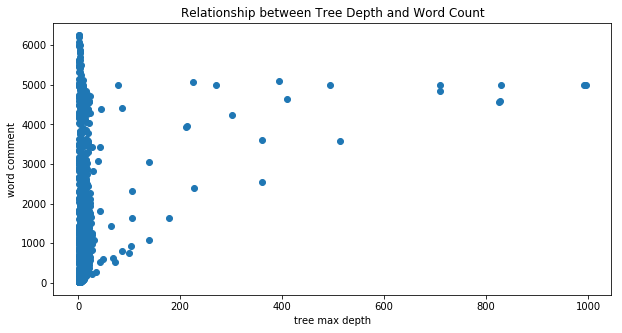

In [508]:
my_trees = list(zip(my_comments,tree_depth,(len(x) for x in my_comments)))
plt.rcParams["figure.figsize"] = [10, 5]
plt.scatter(tree_depth, list(len(x) for x in my_comments))
plt.xlabel('tree max depth')
plt.ylabel('word comment')
plt.title('Relationship between Tree Depth and Word Count')
plt.show()

In [521]:
[x for x in my_trees if x[1]>500]

[('balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls balls b

In my review text, most parse trees have 3 layers, and even for more complicated comments (more words), the depth of parse trees generally does not exceed seven to eight. Very few parse trees have very large layer numbers (greater than 500). After inspection, it is found that the original comments that construct these parse trees have very high repeatability, which indicates that the test of word dependency relationship of highly repeatable reviews is prone to errors.

In [562]:
# information extraction

# 1. extracting repeatability in the comments
def repeatability(s):
    doc = nlp(s.replace("  "," "))
    unique = set([t.text for t in doc])
    return 1-(len(unique)/len(doc))

# 2. extracting bad noun word ratio in the comments
def bad_nones_ratio(s, word_list):
    doc = nlp(s.replace("  "," "))
    bad_nouns = [t for t in doc.noun_chunks if t.text in word_list]
    return len(bad_nouns)/len(doc)

# 3. extracting top n repetitive words in a given POS of a sentence or the whole document that are also contained a reference word list
def freq_words(s, pos, word_list, max_n=5):
    doc = nlp(s.replace("  "," "))
    frequency = {}
    text = list((t.text for t in doc))
    for w in set([t.text for t in doc if t.text in word_list and t.pos_ == pos]):
        frequency[w] = text.count(w)
    return sorted(frequency.items(), key=lambda x:x[1], reverse=True)[:max_n]

# 4. extracting the subjects of certain word list 
def subject_extraction(s, word_list):
    doc = nlp(s.replace("  "," "))
    subject_list = {k:{} for k in word_list}
    for s in doc:
        if s.head.text in word_list and s.dep_ == 'nsubj':
            if s.text in subject_list[s.head.text].keys():
                subject_list[s.head.text][s.text] += 1
            else:
                subject_list[s.head.text][s.text] = 1
    return subject_list
    
# 5. extracting the object of certain word list
def object_extraction(s, word_list):
    doc = nlp(s.replace("  "," "))
    object_list = {k:{} for k in word_list}
    for s in doc:
        if s.head.text in word_list and s.dep_ == 'dobj':
            if s.text in object_list[s.head.text].keys():
                object_list[s.head.text][s.text] += 1
            else:
                object_list[s.head.text][s.text] = 1
    return object_list

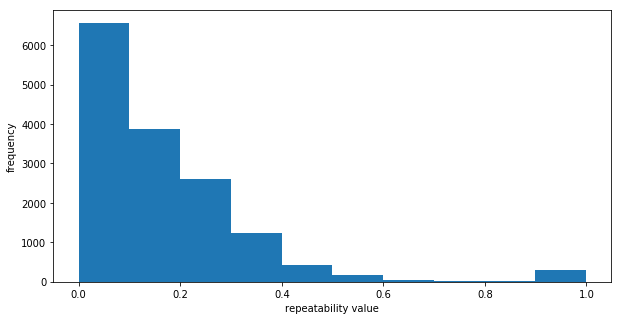

In [557]:
# plot the repeatability histogram of each sentence
rep_list = [repeatability(s) for s in my_comments]
plt.hist(rep_list)
plt.xlabel('repeatability value')
plt.ylabel('frequency')
plt.show()

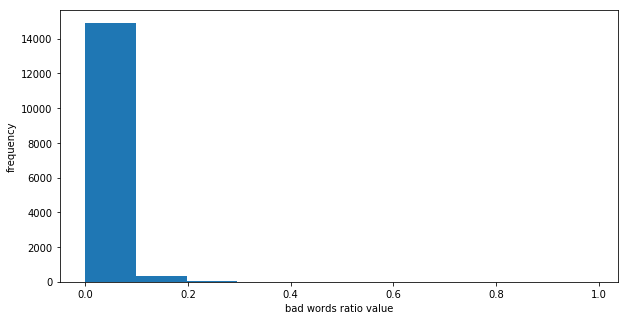

In [561]:
# plot the bad none ratio histogram of each sentence
bad_ratio_list = [bad_nones_ratio(s, my_words) for s in my_comments]
plt.hist(bad_ratio_list)
plt.xlabel('bad words ratio value')
plt.ylabel('frequency')
plt.show()

In [565]:
# capture the top 5 frequently appeared nones in the corpus
whole = ' '.join(my_comments[:200]).replace("  "," ")
freq_verb = freq_words(whole, 'VERB', my_words)
freq_verb

[('cunt', 265), ('fuck', 114), ('shit', 26), ('suck', 13), ('sex', 12)]

In [567]:
# capture the subjects of words in the given word_list from the whole corpus
subject_dict = subject_extraction(whole, dict(freq_verb).keys())
subject_dict

{'cunt': {'you': 1},
 'fuck': {'you': 7,
  'they': 1,
  'mother': 5,
  'r': 1,
  's': 1,
  'i': 10,
  'lowlife': 1,
  'man': 1,
  'it': 1},
 'shit': {'i': 2, 'god': 1},
 'suck': {'you': 2,
  'wikipedia': 1,
  'cock': 1,
  'back': 1,
  'bla': 1,
  'article': 1},
 'sex': {}}

In [568]:
# capture the objects of words in the given word_list from the whole corpus
object_dict = object_extraction(whole, dict(freq_verb).keys())
object_dict

{'cunt': {},
 'fuck': {'mother': 2,
  'yourself': 1,
  'what': 1,
  'hope': 1,
  'you': 5,
  'trollreasons': 1,
  'ing': 1,
  'hole': 1,
  'ed': 7},
 'shit': {'wound': 1, 'head': 1, 'reason': 1, 'god': 1},
 'suck': {'s': 3, 'i': 1},
 'sex': {}}

From the statistics of those selected samples, the repetition rates of words in most toxic comments are not high. But in a few comments, words have a high repetition rate (nearly 1.0) and those comments are very likely to disturb the distribution of the word frequency distribution of the whole datasets. For the toxic vocabulary test, we found that most of the comment sentences contained toxic vocabulary in the reference list, although the proportions of these words were not high. If the same statistics are used for non-toxic comments, we will be able to know more clearly whether this set of reference words are suitable for identifying toxic comments in the target dataset.

In the test of dependencies, I only selected the first 200 comments (a comment sample can contain multiple comments) for inspection. I used verbs as a benchmark to see how the subject and object match. We found that due to the irregular spelling and the lack of some punctuation marks, some recognition results were strange. This reminds us that if we need to analyze dependencies, we should retain more sentence structures like punctuations during preprocessing. This is especially important for texts that are highly repetitive and the structure of the repeated units is relatively simple (e.g., 'like you like you like you', it might be wrongly parsed as "like, you like you, you like you")

# Distributional distances

If we want to compare different corpora, we need a distance or divergence that compares the two distributions.

We will use the: 

+ Kullback-Leibler (KL) divergence
+ $\chi^2$ divergence
+ Kolmogorov-Smirnov (KS) distance
+ Wasserstein distance

### Kullback-Leibler and $x^2$ divergences ###

KL and $\chi^2$ divergences are members of the broader <a "href=https://en.wikipedia.org/wiki/F-divergence" target="_blank">$f$-divergence</a> family, a function of $D_f (P || Q)$ that calculates the difference between two probability distributions P and Q. The KL $f(t)$ is $ t \text{ log } t $, while the $\chi^2$ is $t^2-1$. KL comes from information and $\chi^2$ from measure theory. As such, the KL divergence computes the relative entropy between two distributions--how they differ in bits, while the $\chi^2$ whether the same statistical inferences can be drawn from them both.  

Specifically, given two discrete probability distributions $P$ and $Q$, the Kullback-Leibler divergence from $Q$ to $P$ is defined as:

$D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \log\frac{P(i)}{Q(i)}$.

The [scipy.stats.entropy()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function does the calculation for you, which takes in two arrays of probabilities and computes the KL divergence. Note that the KL divergence is in general not commutative, i.e. $D_{\mathrm{KL}}(P\|Q) \neq D_{\mathrm{KL}}(Q\|P)$ .

Also note that the KL divernce is the sum of elementwise divergences. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which calculates elementwise divergences for you.

The $\chi^2$ Divergence is defined as:

$D_{\mathrm{\chi^2}}(P\|Q) = \sum_i \left(\frac{P(i)}{Q(i)}-1\right)^2$. 

This is also noncommutative, and the code can be drawn directly from scipy.

### Kolmogorov-Smirnov ###

The two-sample Kolmogovorov-Smirnov test statistic calculates the distance between the cumulative distribution function of the two distributions to be compared, and, along with the $x^2$ divergence, is among the most common approaches two calculating a distance in statistics. It can be interpreted as a test of whether two distributions are drawn from the same underlying distribution. As with the others, the code is readily available in scipy.

### Wasserstein Distance ###

When this is computed on a Euclidian metric structure (e.g., numbers of words), this is also known as the earth mover’s distance, because it can be seen as the minimum amount of "work" required to transform $P$ into $Q$, where "work" is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

### Computing ###

To do this we will need to create the arrays, lets compare the Whitehouse releases with the Kennedy releases. First we have to download them and load them into a DataFrame.

In [103]:
kenReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Kennedy', maxFiles = 10)
kenReleases[:5]

download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   
3  https://raw.githubusercontent.com/lintool/Grim...   
4  https://raw.githubusercontent.com/lintool/Grim...   

                                            html_url                    name  \
0  https://github.com/lintool/GrimmerSenatePressR...  01Apr2005Kennedy14.txt   
1  https://github.com/lintool/GrimmerSenatePressR...  01Aug2005Kennedy12.txt   
2  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy10.txt   
3  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy11.txt   
4  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy12.txt   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   
3  raw/Kennedy/01Aug2006Kennedy11.txt   
4  raw/Kennedy/01Aug2006Kennedy12.txt   

                                                text  
0           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...  
1           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...  
2           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...  
3           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...  
4           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...

Then we can tokenize, stem and remove stop words, like we did for the Whitehouse press releases

In [104]:
kenReleases['tokenized_text'] = kenReleases['text'].apply(lambda x: word_tokenize(x))
kenReleases['normalized_tokens'] = kenReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

Now we need to compare the two collection of words, remove those not found in both, and assign the remaining ones indices.

In [105]:
whWords = set(whReleases['normalized_tokens'].sum())
kenWords = set(kenReleases['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = whWords & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student']

208

Now we can count the occurrences of each word in the corpora and create our arrays. Note that we don't have to use numpy arrays as we do here. We could just use a list, but the arrays are faster in numpy so we encourage you to get in the habit of using them.

In [106]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

whProbArray = makeProbsArray(whReleases['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(kenReleases['normalized_tokens'], overlapWordsDict)
kenProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

1.0

We can now compute the KL divergence. Pay attention to the asymmetry. Use [the Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence), which is the average KL divergence between each distribution and the average of both distributions (i.e., the midpoint), if you want symmetry.

In [107]:
wh_kenDivergence = scipy.stats.entropy(whProbArray, kenProbArray)
print (wh_kenDivergence)
ken_whDivergence = scipy.stats.entropy(kenProbArray, whProbArray)
print (ken_whDivergence)

0.632804454460187
0.5784905983449495


Then, we can do the elementwise calculation and see which words best distinguish the two corpora.

In [108]:
wh_kenDivergence_ew = scipy.special.kl_div(whProbArray, kenProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = wh_kenDivergence_ew
kl_df[:10]

word  elementwise divergence
0     science                0.001896
1       white                0.000073
2    senators                0.000818
3        join                0.000055
4   testimony                0.000055
5        loss                0.000055
6       focus                0.000055
7      public                0.000110
8     advance                0.000055
9  scientific                0.000392

In [109]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

word  elementwise divergence
223        iraq                0.094839
225        bush                0.048099
157    american                0.025871
217        stem                0.023705
50          law                0.022781
134  department                0.019537
230      member                0.013240
117         war                0.012655
58      program                0.011213
118     country                0.010187

Now we will apply what we learned today 
First, let's transform every text into normalized tokens. Note that in this first step, no stopword is removed.
We'll use only the first 11 movies: you are welcome to try more.

In [110]:
corpora = []
for index, row in movie_df.iterrows():
    if len(corpora) > 10:
        break
    corpora.append(row['Tokenized Texts'])

Then, let's separate the normalized tokens into stopwords and non-stopwords.

In [111]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

Define some covenient funtions for calculating divergence and distances.

In [578]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

Now we will calculate the KL divergence for each pair of corpora, turn the results into a matrix, and visualize the matrix as a heatmap. Recall that $D_{\mathrm{KL}}(P\|Q)$ measures the amount of information loss when $Q$ is used to approximate $P$. Here, the rows are the $P$s used for calculating KL divergences, and the columns are the $Q$s. So, each cell measures the amount of information loss when the word distribution of the column text is used to approximate the word distribution of the row text. Because the KL divergence is directional, such that the divergence of $P$ from $Q$ is different from the same of $Q$ from $P$, the matrix is assymetric and contains unique information above and below the diagonal. The same is true for the $\chi^2$ divergence.

In [113]:
len(corpora)

11

In [114]:
fileids = list(movie_df['Movie Name'])[0:11]

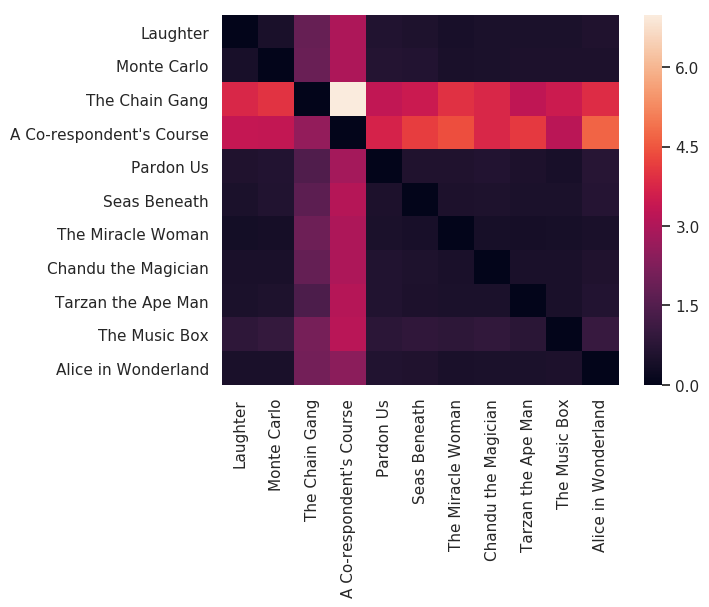

In [115]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()


To reveal more patterns, let's do a multidimensional scaling of the matrix.

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


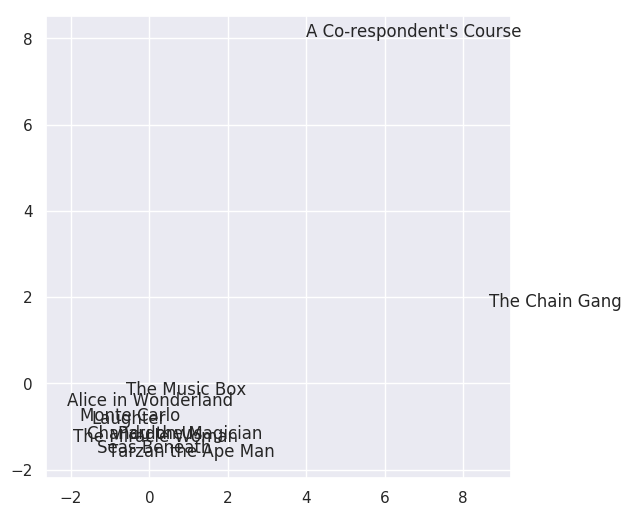

In [116]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

A co-respondent's course and The Chain Gang are away from the others - any guesses why?

We may just want to focus on the distrbution of stopwords or non-stopwords. Let's do the analysis again first for stopwords and then for non-stopwords.

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


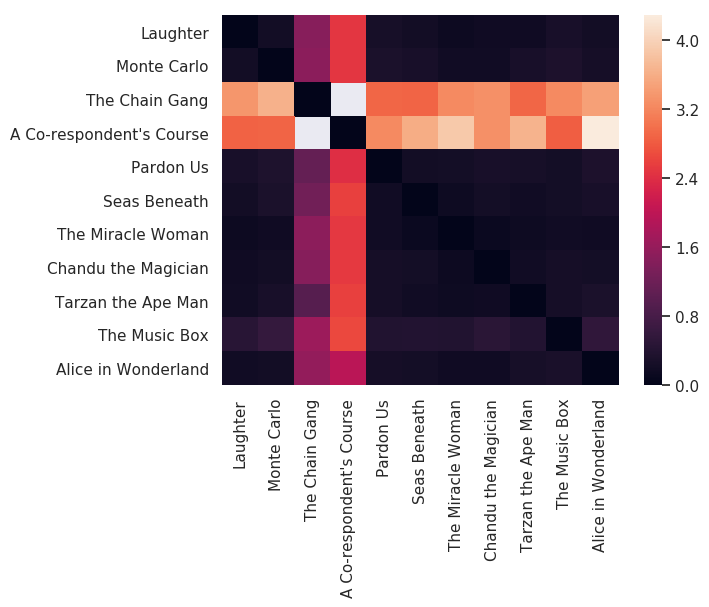

In [117]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

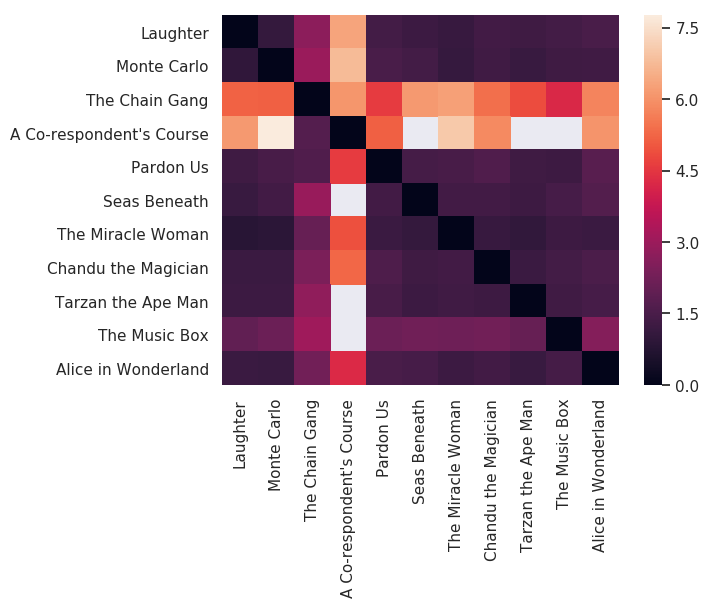

In [118]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

Now we compute the same for the assymmetric $\chi^2$ Divergence.

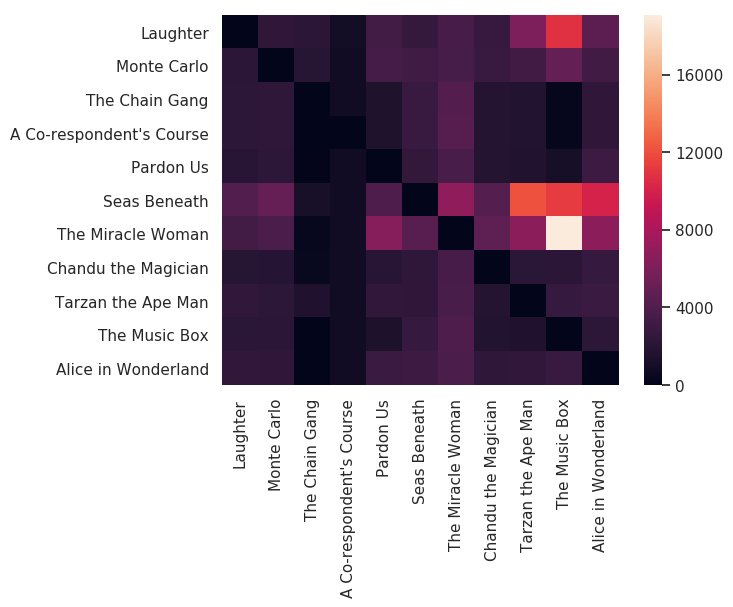

In [119]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

For the KS distance:

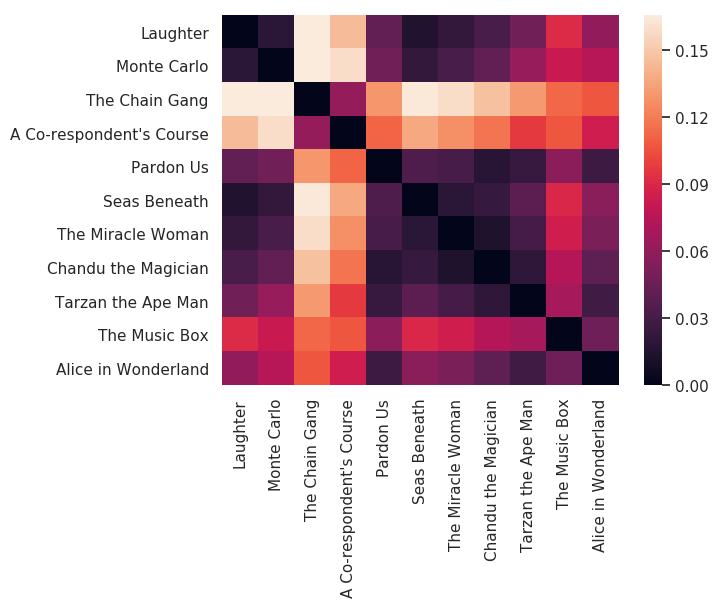

In [120]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

And finally for the Wasserstein or "earth mover's" Distance.

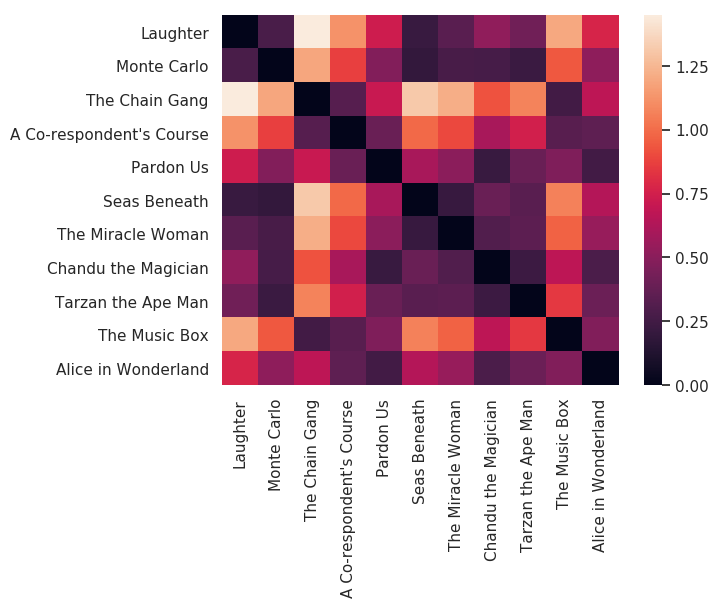

In [121]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

You can see that decade X is highly divergent and this makes reading the plot somewhat difficult. Let's fix this by taking the log of each cell, which will reduce the distance of decode X from other texts as an outlier.

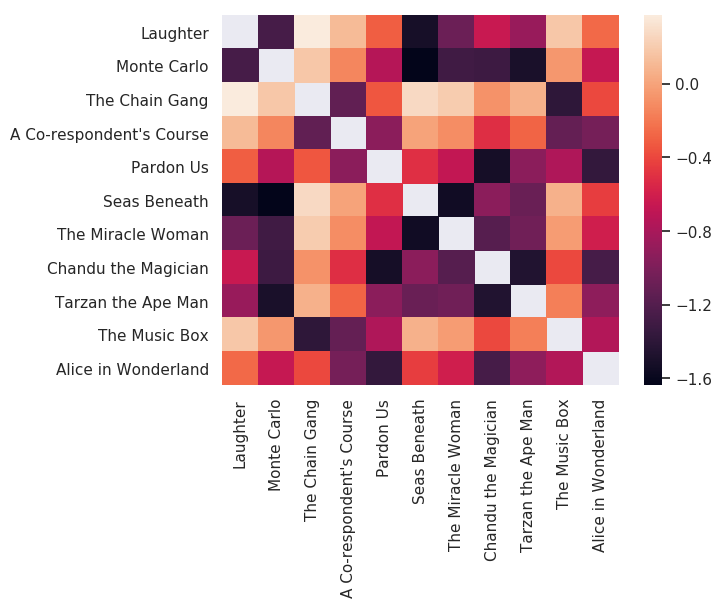

In [122]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

We only tried 11 movies, and from the same time period, so our signals might not be too interesting. What about different time periods?

An interesting experiment to maybe get some clearer signals: documents by decade in the Davies Corpus Of Historial American English (COHA) and see if we can detect patterns between them. 

If we want to rerun this on a new data set of our own composition, we can be a bit more efficient with our coding. Let's use the Shakespeare texts from last week as example: 

In [123]:
shakespeare_df = lucem_illud_2020.loadTextDirectory('../data/Shakespeare')

Now we stem and remove stopwords

In [124]:
shakespeare_df['tokenized_text'] = shakespeare_df['text'].apply(lambda x: word_tokenize(x))
shakespeare_df['normalized_tokens'] = shakespeare_df['tokenized_text'].apply(lambda x: normalizeTokens(x))

Create the corpus file and generate the heatmap:

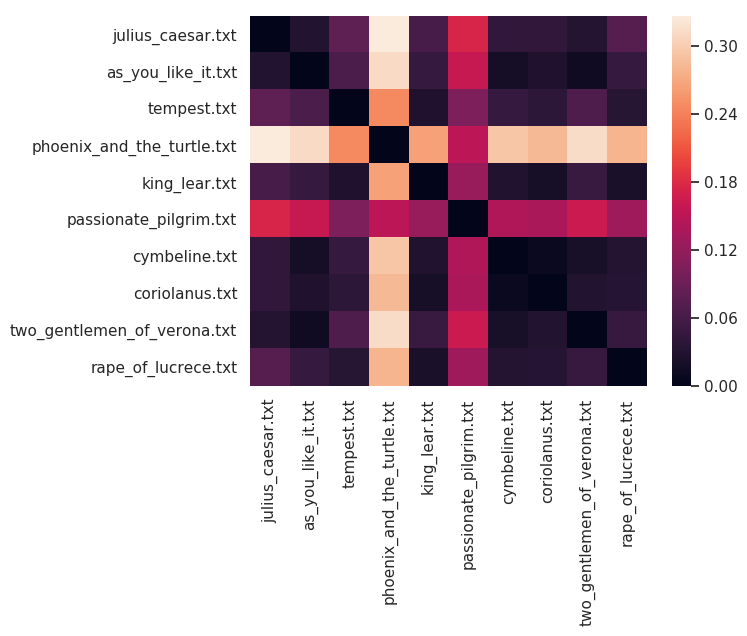

In [125]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 #The bigger this number the slower it will run, you can also try selecting your own plays
fileids_sp = list(shakespeare_df[:num_of_texts].index)
corpora_sp = list(shakespeare_df[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

What are "The Passionate Pilgrim" and "The Phoenix and the Turtle"? Little known poems by Shakespeare that are unsurprisingly hard to classify, as they are so different from everything else he wrote.

## <span style="color:red">*Exercise 6*</span>

<span style="color:red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better? 

<span style="color:red">**Stretch**: Calculate the <a "href=https://en.wikipedia.org/wiki/Jensen–Shannon_divergence" target="_blank">Jensen-Shannon Divergence</a> between your four corpora. What is the relationship between the KL and JS divergences?</span> 

In [585]:
# produce 4 different corpora, I chose them from the comments dataset
my_corpora = [np.array(my_normalized_tokens[:20]), np.array(my_normalized_tokens[20:40]).sum(),
              np.array(my_normalized_tokens[40:60]), np.array(my_normalized_tokens[60:80]).sum()]

In [607]:
# build a function to plot heat maps and return the distance/divergence matrix
def diff_matrix_plot(corporas, measure):
    L = []
    for p in corporas:
        l = []
        for q in corporas:
            l.append(Divergence(p,q, difference=measure))
        L.append(l)
    fig = plt.figure()
    div = pandas.DataFrame(np.array(L),columns = range(1,5), index = range(1,5))
    ax = sns.heatmap(div)
    plt.show()
    return np.array(L)

def MDS_plot(div):
    mds = sklearn.manifold.MDS()
    pos = mds.fit(div).embedding_
    x = pos[:,0]
    y = pos[:,1]
    fig, ax = plt.subplots(figsize = (6,6))
    plt.scatter(x, y)
    for i in range(4):
        ax.annotate('corpora'+str(i+1), (x[i],y[i]))

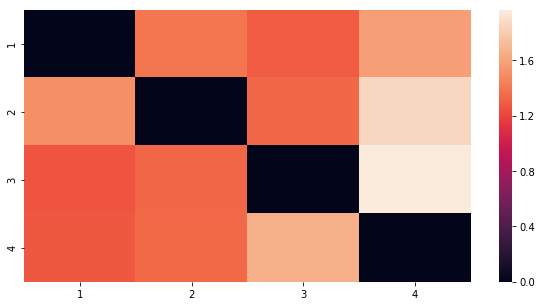

In [617]:
# KL
KL_div = diff_matrix_plot(my_corpora, 'KL')

F:\Anaconda3\lib\site-packages\sklearn\manifold\mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


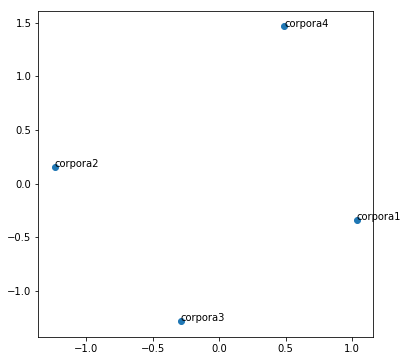

In [624]:
MDS_plot(KL_div)

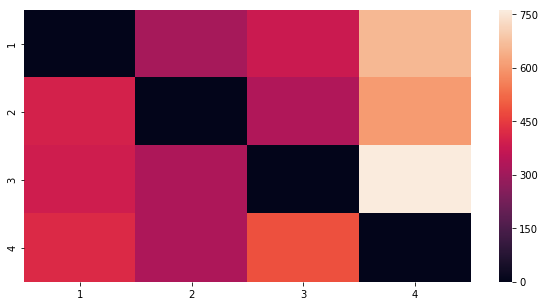

In [634]:
# Chi2
Chi_div = diff_matrix_plot(my_corpora, 'Chi2')

F:\Anaconda3\lib\site-packages\sklearn\manifold\mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


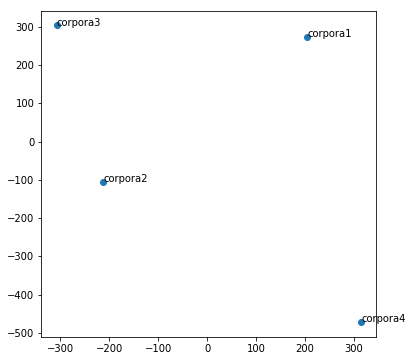

In [635]:
MDS_plot(Chi_div)

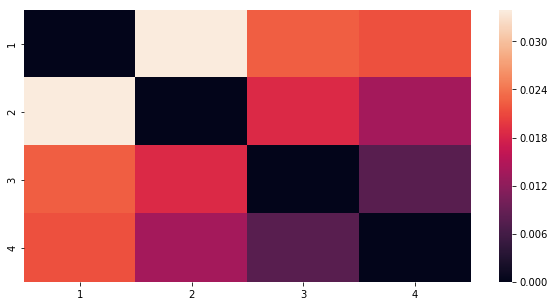

In [630]:
# KS
KS_div = diff_matrix_plot(my_corpora, 'KS')

F:\Anaconda3\lib\site-packages\sklearn\manifold\mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


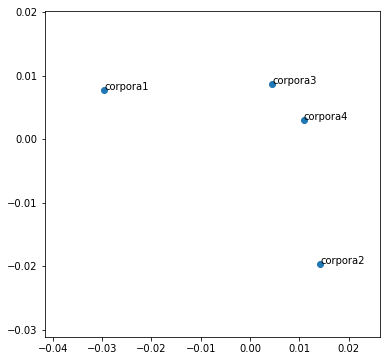

In [631]:
MDS_plot(KS_div)

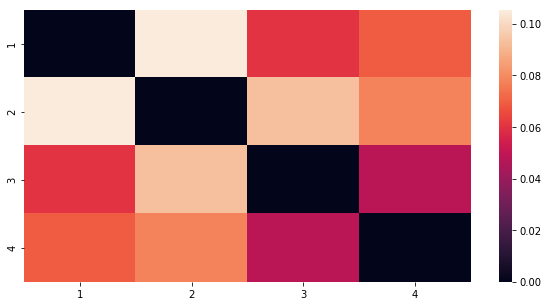

In [632]:
# Wasserstein
W_div = diff_matrix_plot(my_corpora, 'Wasserstein')

F:\Anaconda3\lib\site-packages\sklearn\manifold\mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


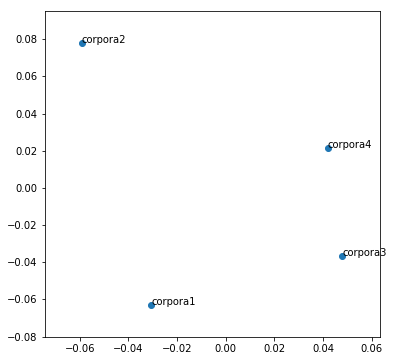

In [636]:
# MDS
MDS_plot(W_div)

From the results of the above four statistics, although these samples come from the same online review set, there are differences that cannot be ignored in the distribution of words. Different statistics show different results, but in the Wasserstein and KS statistics, we find that the word frequency distributions of the third and fourth samples are closer. So I think the last two statistics are more accurate because the results show greater consistency. And the KS test can handle the non-equivalence of the samples in the two sets of data (word a in A but not in B), while KL and Chi2 are defective in this regard. 

In [641]:
# JS divergences, re-define the Divergence function
def js_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.spatial.distance.jensenshannon(p, q)**2

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, Wass or JS"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "JS":
        return js_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

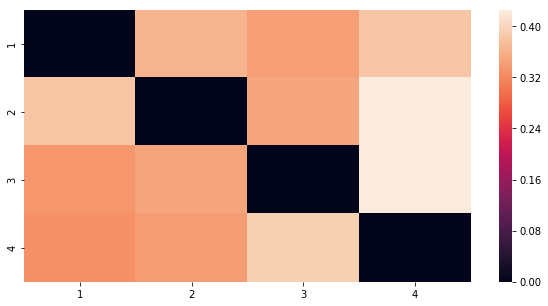

F:\Anaconda3\lib\site-packages\sklearn\manifold\mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


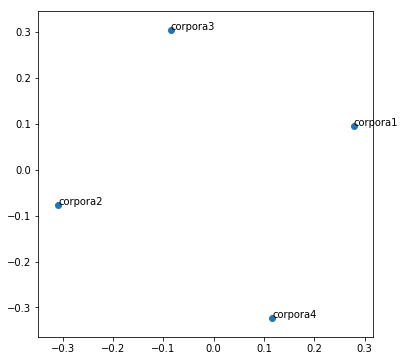

In [642]:
# JS
JS_div = diff_matrix_plot(my_corpora, 'JS')
MDS_plot(JS_div)

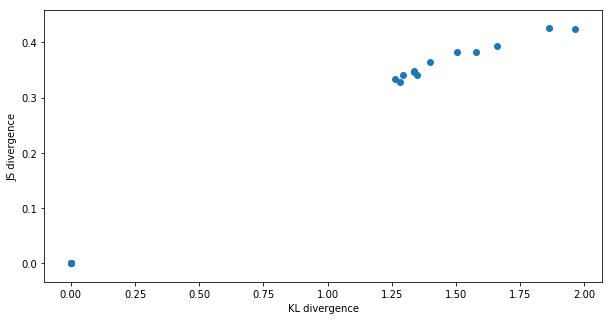

In [651]:
plt.scatter(KL_div.flatten(),JS_div.flatten())
plt.xlabel('KL divergence')
plt.ylabel('JS divergence')
plt.show()

The JS divergence is the result of smoothing the KL divergence (average between two distribution). As can be seen from the figure above, the results are highly consistent.